#**MiniProject 3: Multi-label Classification of Image Data**
###COMP 551, Fall 2020, McGill University
###Mathew Marques (260804167)
###David Castonguay (260804528)
###Marco Guida (260803123)

In [1]:
import numpy as np
import random
import numpy.linalg as lia
import pandas as pd
import h5py
import random
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn import datasets
from sklearn.cluster import KMeans

#to plot images
import matplotlib.image as mpimg 
#to read images

import cv2 
#open CV library for Python
import numpy as np
import torch
import torchvision
from torchvision.ops import nms
import torchvision.transforms as transforms
from statistics import stdev
from skimage.transform import rescale, resize, downscale_local_mean

REMINDER TO ADJUST PATH IF RUNNING ON GOOGLE COLAB

In [2]:
from google.colab import drive
drive.mount('/content/drive') #Read in the image

path = '/content/drive/My Drive/COMP_551/Mini_Project_3/Multi-Label-Classification-of-Image-Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install opencv-python==4.4.0.44
!pip install opencv-contrib-python==4.4.0.44
!pip list

Package                       Version        
----------------------------- ---------------
absl-py                       0.10.0         
alabaster                     0.7.12         
albumentations                0.1.12         
altair                        4.1.0          
argon2-cffi                   20.1.0         
asgiref                       3.3.1          
astor                         0.8.1          
astropy                       4.1            
astunparse                    1.6.3          
async-generator               1.10           
atari-py                      0.2.6          
atomicwrites                  1.4.0          
attrs                         20.3.0         
audioread                     2.1.9          
autograd                      1.3            
Babel                         2.9.0          
backcall                      0.2.0          
beautifulsoup4                4.6.3          
bleach                        3.2.1          
blis                          0.4.

In [4]:
def loadBGRImage(path):
    image = BGR(cv.imread(path))
    return image

def loadGreyImage(path):
    image = cv.imread(path, cv.IMREAD_GRAYSCALE)
    return image

def BGR(image):
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
    return image

def displayGreyImage(image, imageName):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap = 'gray')
    plt.title(imageName)
    plt.show()

def displayGreyWindows(image, imageName):
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap = 'gray')
    plt.title(imageName)
    plt.show()
    
def displayBGRImage(image, imageName, size):
    plt.figure(figsize=(size, size))
    plt.imshow(image)
    plt.title(imageName)
    plt.show()
    
def displayBGRImageLarge(image, imageName):
    plt.figure(figsize=(18, 18))
    plt.imshow(image)
    plt.title(imageName)
    plt.show()
    
def imageSideBySide(images, imageNames,size):
    row = np.ceil(len(images)/20)
    fig=plt.figure(figsize=(size, size/2))
    for i, image in enumerate(images):
        fig.add_subplot(row, 20, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(imageNames[i])
    plt.show()

## ORIGINALITY/ CREATIVITY: Additional Dataset

In [5]:
# load the trainset 
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True)
# load the testset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True)
# find the mean and std of the trainset
mean1 = trainset.data.float().mean()/255
std1 = trainset.data.float().std()/255

# find the mean and std of the testset
mean2 = testset.data.float().mean()/255
std2 = testset.data.float().std()/255

print('mean1: '+ str(mean1) +', std1:'+ str(std1) +', mean2: '+ str(mean2) +', std2: '+ str(std2))


# initialize transform for the trainset to normalize data appropriately
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean1,), (std1,))]) # mean (0.1307) and std (0.3081) are calculated above 

# initialize transform for the testset to normalize data appropriately
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((mean2,), (std2,))]) # mean (0.1325) and std (0.3105) are calculated above 


# load the trainset with transform
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
# load batches of size 32 from the trainset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

# load the testset with transform2 
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform2)
# load batches of size 32 from the testset
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)


# NOTE: When loading the datasets we use transform and transform2 because the test set has slightly different mean and std values than the trainset.
# Therefore, for better accuracy we use 2 separate transforms on each dataset to better normalize the data, although as seen in the Tutorial we can also re-use the transform used for the trainset.


mean1: tensor(0.1307), std1:tensor(0.3081), mean2: tensor(0.1325), std2: tensor(0.3105)


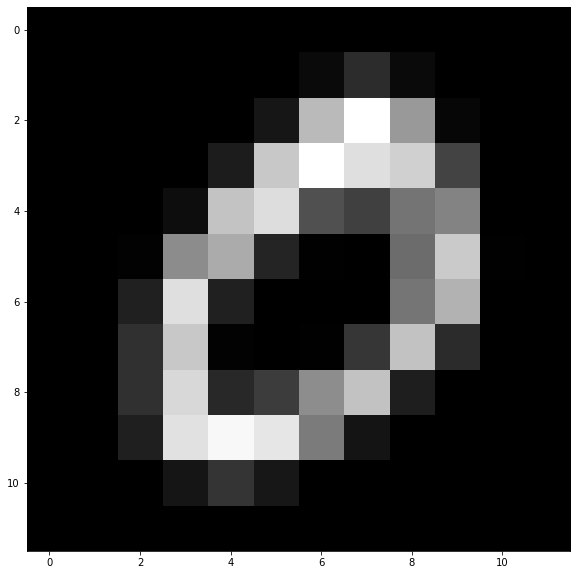

In [71]:
reshaped_MNIST_dataset = []
for data_train in trainset.data:
    reshaped_image_train = resize(data_train, (12,12), anti_aliasing=True)
    reshaped_MNIST_dataset.append(reshaped_image_train)

for data_test in testset.data:
    reshaped_image_test = resize(data_test, (12,12), anti_aliasing=True)
    reshaped_MNIST_dataset.append(reshaped_image_test)

displayGreyImage(reshaped_MNIST_dataset[1], "")

In [84]:
train_labels_extra = []
test_labels_extra = []
for i, (data, labels) in enumerate(trainset):
    train_labels_extra.append(labels)
for i, (data, labels) in enumerate(testset):
    test_labels_extra.append(labels)

## Pre-Processing

In [7]:
start = 25, 26
size = 14, 12

f = h5py.File(path+'MNIST_synthetic.h5', 'r')

list(f.keys())

['test_dataset', 'train_dataset', 'train_labels']

In [8]:
train_dataset = np.squeeze(np.array(f["train_dataset"])).copy()
train_labels = np.squeeze(np.array(f["train_labels"])).copy()
test_dataset = np.squeeze(np.array(f["test_dataset"])).copy()

singulars_digits = []
singulars_labels = []

doubles_digits = []
doubles_labels = []

triples_digits = []
triples_labels = []

quadruples_digits = []
quadruples_labels = []

quintuples_digits = []
quintuples_labels = []


for i, labels in enumerate(train_labels):
    if labels[1] == 10:
        singulars_digits.append(train_dataset[i])
        singulars_labels.append(train_labels[i])
        
    if labels[1] != 10 and labels[2] == 10:
        doubles_digits.append(train_dataset[i])
        doubles_labels.append(train_labels[i])
        
    if labels[2] != 10 and labels[3] == 10:
        triples_digits.append(train_dataset[i])
        triples_labels.append(train_labels[i])
        
    if labels[3] != 10 and labels[4] == 10:
        quadruples_digits.append(train_dataset[i])
        quadruples_labels.append(train_labels[i])
        
    if labels[4] != 10:
        quintuples_digits.append(train_dataset[i])
        quintuples_labels.append(train_labels[i])

In [9]:
singulars_digits = np.array(singulars_digits)     
doubles_digits = np.array(doubles_digits)  
triples_digits = np.array(triples_digits)    
quadruples_digits = np.array(quadruples_digits)    
quintuples_digits = np.array(quintuples_digits)    

singulars_labels = np.array(singulars_labels).T[0]
doubles_labels = np.array(doubles_labels).T[0:2].T
triples_label = np.array(triples_labels).T[0:3].T
quadruples_label = np.array(quadruples_labels).T[0:4].T
quintuples_label = np.array(quintuples_labels).T[0:5].T

In [10]:
final_singulars_dataset = []
final_singulars_labels = list(singulars_labels)
for i, digit in enumerate(singulars_digits):
    final_singulars_dataset.append(digit[26:38,26:38])
    
final_doubles_dataset = []
final_doubles_labels = []
for i, digit in enumerate(doubles_digits):
    final_doubles_dataset.append(digit[26:38,20:32])
    final_doubles_dataset.append(digit[26:38,32:44])
    final_doubles_labels.append(doubles_labels[i][0])
    final_doubles_labels.append(doubles_labels[i][1])

final_triples_dataset = []
final_triples_labels = []
for i, digit in enumerate(triples_digits):
    final_triples_dataset.append(digit[26:38,14:26])
    final_triples_dataset.append(digit[26:38,26:38])
    final_triples_dataset.append(digit[26:38,38:50])
    final_triples_labels.append(triples_labels[i][0])
    final_triples_labels.append(triples_labels[i][1])
    final_triples_labels.append(triples_labels[i][2])
    
final_quadruples_dataset = []
final_quadruples_labels = []
for i, digit in enumerate(quadruples_digits):
    final_quadruples_dataset.append(digit[26:38,8:20])
    final_quadruples_dataset.append(digit[26:38,20:32])
    final_quadruples_dataset.append(digit[26:38,32:44])
    final_quadruples_dataset.append(digit[26:38,44:56])
    final_quadruples_labels.append(quadruples_labels[i][0])
    final_quadruples_labels.append(quadruples_labels[i][1])    
    final_quadruples_labels.append(quadruples_labels[i][2])
    final_quadruples_labels.append(quadruples_labels[i][3]) 
    
final_quintuples_dataset = []
final_quintuples_labels = []
for i, digit in enumerate(quintuples_digits):
    final_quintuples_dataset.append(digit[26:38,2:14])
    final_quintuples_dataset.append(digit[26:38,14:26])
    final_quintuples_dataset.append(digit[26:38,26:38])
    final_quintuples_dataset.append(digit[26:38,38:50])
    final_quintuples_dataset.append(digit[26:38,50:62])
    final_quintuples_labels.append(quintuples_labels[i][0])
    final_quintuples_labels.append(quintuples_labels[i][1])
    final_quintuples_labels.append(quintuples_labels[i][2])
    final_quintuples_labels.append(quintuples_labels[i][3])
    final_quintuples_labels.append(quintuples_labels[i][4])

In [11]:
merged_dataset = final_singulars_dataset + final_doubles_dataset + final_triples_dataset + final_quadruples_dataset + final_quintuples_dataset
merged_labels = final_singulars_labels + final_doubles_labels + final_triples_labels + final_quadruples_labels + final_quintuples_labels

extra = False
if extra:
    merged_dataset = merged_dataset + reshaped_MNIST_dataset
    merged_labels = merged_labels + train_labels_extra + test_labels_extra

In [12]:
count = 0

for digit in range(10):
    digit_count = list(merged_labels).count(digit)
    print(f"number of {digit}'s in train dataset: {digit_count}")
    count += digit_count

print("total number of digits in train dataset:", count)

number of 0's in train dataset: 16379
number of 1's in train dataset: 18819
number of 2's in train dataset: 17095
number of 3's in train dataset: 17220
number of 4's in train dataset: 16393
number of 5's in train dataset: 15275
number of 6's in train dataset: 16401
number of 7's in train dataset: 17611
number of 8's in train dataset: 16175
number of 9's in train dataset: 16518
total number of digits in train dataset: 167886


In [13]:
digitsTrainingSetSize = int(np.ceil(0.8 * len(merged_dataset)))
digitsValidationSetSize = int(len(merged_labels) - digitsTrainingSetSize)

xValidationSet = []
yValidationSet = []

for index, digit in enumerate(merged_dataset[0:digitsValidationSetSize]):
    xValidationSet.append(digit)
    yValidationSet.append(merged_labels[index])

xTrainingSet = []
yTrainingSet = []

start = len(xValidationSet)

for i, digit in enumerate(merged_dataset[start:]):
    xTrainingSet.append(digit)
    yTrainingSet.append(merged_labels[i+start])

## Finding all digits in an image

In [ ]:
def bounding_box(image, threshold=30):
    thresh_train_dataset = image.copy()
    thresh_train_dataset[thresh_train_dataset>threshold] = 255
    thresh_train_dataset[thresh_train_dataset!=255] = 0
  
    i,j = np.where(thresh_train_dataset[:,:]!=0)

    bottom_bound = np.min(i)
    top_bound = np.max(i)
    left_bound = np.min(j)
    right_bound = np.max(j)
    
    h = top_bound-bottom_bound
    w = right_bound-left_bound

    bounded_train_dataset = image[bottom_bound-3:top_bound+4,left_bound-3:right_bound+4]
    return bounded_train_dataset

In [14]:
def create_boxes(image, dig_centers):
    
    n_dig = len(dig_centers)
    digits = []
    if n_dig == 1:
        digits.append(image[26:38,26:38])
    elif n_dig == 2:
        digits.append(image[26:38,20:32])
        digits.append(image[26:38,32:44])
    elif n_dig == 3:
        digits.append(image[26:38,14:26])
        digits.append(image[26:38,26:38])
        digits.append(image[26:38,38:50])
    elif n_dig == 4:
        digits.append(image[26:38,8:20])
        digits.append(image[26:38,20:32])
        digits.append(image[26:38,32:44])
        digits.append(image[26:38,44:56])
    elif n_dig == 5:
        digits.append(image[26:38,2:14])
        digits.append(image[26:38,14:26])
        digits.append(image[26:38,26:38])
        digits.append(image[26:38,38:50])
        digits.append(image[26:38,50:62])

    return digits

In [15]:
import random as rng
rng.seed(12345)
def find_n_digits(src, val=30):
    threshold = val

    src_gray = cv2.blur(src, (1,1))

    #src_gray = bounding_box(src_gray,30)

    # use canny-edge detection to find edges in image of digits
    canny_output = cv2.Canny(src_gray, threshold, threshold * 2)
    
    # create/ find contours of digits using canny-edges
    contours, _ = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # find the centers and radius using the contours
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
        centers[i], radius[i] = cv2.minEnclosingCircle(contours_poly[i])
    

    arr_centers = np.asarray(centers)
    arr_radius  = np.asarray(radius)

    # sorting the digit centers found so they are in order from left to right along the image
    centers_inds = np.argsort(arr_centers[:,0])
    sorted_centers = arr_centers[centers_inds[::]]
    sorted_radius = arr_radius[centers_inds[::]]
    
    # removing computed centers that have a radius that is too small to be a digit or too large to be a single digit
    new_centers = [sorted_centers[i] for i in range(len(sorted_centers)) if sorted_radius[i]>1 and sorted_radius[i]<7]
    new_radius  = [sorted_radius[i] for i in range(len(sorted_radius)) if sorted_radius[i]>1 and sorted_radius[i]<7] 
    
    # print centers and radius of digits
    """
    for i, x in enumerate(new_centers):
      print("new centers", x,"new radius", new_radius[i])
    """

    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    for i in range(len(new_centers)):
        color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
        cv2.circle(drawing, (int(new_centers[i][0]), int(new_centers[i][1])), int(new_radius[i]), color, 2)
    
    # display image of contours using the centers and radius
    """
    displayGreyImage(drawing, "contours")
    """
    
    boxes = []
    scores = []
    boxes_tensor = torch.empty(size=(len(new_centers), 4))
    scores_tensor = torch.empty(len(new_centers))
    for i, x in enumerate(new_centers):
        bottom = np.floor(x[1]-new_radius[i]).astype(int)
        top = np.ceil(x[1]+new_radius[i]).astype(int)
        left = np.floor(x[0]-new_radius[i]).astype(int)
        right = np.ceil(x[0]+new_radius[i]).astype(int)
        
        # print the four corners of each bounding box
        """
        print(f'bottom: {bottom} top: {top} left: {left} right: {right}')
        """
        box = src_gray[bottom:top, left:right]
        score = box.sum()
        scores.append(score)

        boxes.append(box)
        """
        displayGreyImage(boxes[i], i)
        """
    
    j_list = np.asarray(new_centers)
    j_list = np.asarray(j_list[:,0])
    j_list = np.sort(j_list)
    
    # create a list of lists, put the first value of the source data in the first index of the list
    lists = [[j_list[0]]]
    
    radius_lists = [[new_radius[0]]]
    
    for i, x in enumerate(j_list[1:]):
       
        # if the gap from the current digits center to the previous digit center is more than 6
        #  then we have found a new digit so split the groups for these centers
        # Note: the previous item is the last item in the last list
        # Note: the '> 6' is the part you'd modify to make it stricter or more relaxed
        if np.abs(x - (lists[-1][-1])) > 6: #radius[i] (new_radius[i]+new_radius[i+1])*2/3
            lists.append([])
            radius_lists.append([])
        lists[-1].append(x)
        radius_lists[-1].append(new_radius[i])
   
    digit_centers = np.asarray([np.mean(lists[i]) for i in range(len(lists))]).astype(int)
    digit_radius = np.asarray([np.max(radius_lists[i]) for i in range(len(radius_lists))]).astype(int)
    
    # creating final boxes with create_boxes helper function
    final_boxes = create_boxes(src, digit_centers)

    """
    for i in range(len(final_boxes)):
        displayGreyImage(final_boxes[i],"")
    """
    
    n_digits = len(final_boxes)

    return final_boxes, n_digits

###This is the original implementation of finding digits with manual image segmentation without OpenCV
NO NEED TO RUN IT IS NOT BEING USED FOR THE FINAL IMPLEMENTATION


In [ ]:
def find_digits(train_dataset, size):
    thresh_train_dataset = train_dataset.copy()
    thresh_train_dataset[thresh_train_dataset>30] = 255
    thresh_train_dataset[thresh_train_dataset!=255] = 0
    
    i,j = np.where(thresh_train_dataset[:,:]!=0)
    
    bottom_bound = np.min(i)
    top_bound = np.max(i)
    left_bound = np.min(j)
    right_bound = np.max(j)
    

    h = top_bound-bottom_bound
    w = right_bound-left_bound

    bounded_train_dataset = train_dataset[bottom_bound-1:top_bound+2,left_bound-1:right_bound+2]
    thresh = bounded_train_dataset.copy()
    thresh[thresh>30] = 255
    thresh[thresh!=255] = 0

    seg = np.where(np.any(thresh, axis=0)==0)
    seg_list = np.asarray(seg)
    seg_list = seg_list[0]

    from statistics import stdev
    
    if len(seg_list)>2:
        # create a list of the gaps between the consecutive values
        gaps = [y - x for x, y in zip(seg_list[:-1], seg_list[1:])]
        # calculate the standard deviation for the gaps
        sd = stdev(gaps)

        # create a list of lists, put the first value of the source data in the first
        lists = [[seg_list[0]]]
        for x in seg_list[1:]:
            # if the gap from the current item to the previous is more than 1.5 SD
            # Note: the previous item is the last item in the last list
            # Note: the '> 1.5' is the part to make it stricter or more relaxed
            if sd<1.5 and sd>0:
                if (x - lists[-1][-1]) / (sd+1e-18) > 1.5:
                    # then start a new list
                    lists.append([])
              # add the current item to the last list in the list
                lists[-1].append(x)
            elif sd==0:
                if (x - lists[-1][-1])>1:
                    lists.append([])
                lists[-1].append(x)
            else:
                if (x - lists[-1][-1]) / (sd+1e-18) > 0.8:
                  # then start a new list
                  lists.append([])
                # add the current item to the last list in the list
                lists[-1].append(x)

        splits = np.asarray([np.ceil(np.mean(lists[i])) for i in range(len(lists))]).astype(int)

    else:
        splits = np.asarray(seg_list)

    n_digits = len(splits)-1
    digits = []
    for i in range(n_digits):
        temp = bounded_train_dataset[:,splits[i]:splits[i+1]]
        # if temp is less than recommeded size first pad on left and then on both sides
        temp_padded = temp.copy()
        if (temp.shape[0] != size) or  (temp.shape[1] != size):
            diff_y = size-temp.shape[0]
            split_diff_y = diff_y//2
            remainder_diff_y = diff_y%2
            diff_x = size-temp.shape[1]
            split_diff_x = diff_x//2
            remainder_diff_x = diff_x%2
            temp_padded = np.pad(temp, ((split_diff_y+remainder_diff_y,split_diff_y),(split_diff_x+remainder_diff_x,split_diff_x)))

        digits.append(temp_padded)
  
    return digits, n_digits

### Testing the performance of finding the number of digits

In [ ]:
wrong = 0 
wrong_arr = []
wrong_arr_index = []
correct = []

for i, sample in enumerate(train_dataset):
    snips, n_dig = find_n_digits(sample)
    real_num_digits = 5 - list(train_labels[i]).count(10)

    if(n_dig != real_num_digits):
        print("incorrect at index:", i)
        wrong += 1
        wrong_arr.append(snips)
        wrong_arr_index.append(i)  

print("total percentage incorrect:", wrong / len(train_dataset) * 100, "%")

incorrect at index: 2903
incorrect at index: 4555
incorrect at index: 7230
incorrect at index: 7472
incorrect at index: 12016
incorrect at index: 12127
incorrect at index: 13485
incorrect at index: 16017
incorrect at index: 18127
incorrect at index: 19418
incorrect at index: 19580
incorrect at index: 19752
incorrect at index: 20317
incorrect at index: 20829
incorrect at index: 24262
incorrect at index: 25284
incorrect at index: 28261
incorrect at index: 32014
incorrect at index: 32944
incorrect at index: 32954
incorrect at index: 33012
incorrect at index: 38206
incorrect at index: 48432
incorrect at index: 50390
incorrect at index: 51039
total percentage incorrect: 0.044642857142857144 %


### Find batch size

In [23]:
num_test_digits = 0

for i, sample in enumerate(test_dataset):
    images, n_digits = find_n_digits(sample)
   
    num_test_digits += n_digits

divs = []

for div in range(1, 100):
    if(num_test_digits % (div) == 0):
        divs.append(div)

batch_size = divs[-1]
print(batch_size)

17


## CNN

Creating batches

In [24]:
def create_batches(input_array, label_array, batch_size):
    batched = []
    label_batched = []
    
    for i in range(np.floor(len(input_array)/batch_size).astype(int)):
        batched.append(np.expand_dims((np.array(input_array[i*batch_size:i*batch_size+batch_size])).astype(np.single),axis=1))
        label_batched.append(label_array[i*batch_size:i*batch_size+batch_size])
        
    return np.array(batched), label_batched

Creating CNN: class Net

In [91]:
class Net(nn.Module):
    def __init__(self, h_layers, stride=1, kernel=3):
        self.num_layers = len(h_layers)
        self.h_layers = h_layers      
        self.convs = []
        self.stride = stride
        self.kernel = kernel
        
        super(Net, self).__init__()

        final_pad = self.kernel - 1
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=self.kernel, stride=self.stride, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=self.kernel, stride=self.stride, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=self.kernel, stride=self.stride, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=self.kernel, stride=self.stride, padding=final_pad),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(3 * 3 * 256, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

## Train CNN for hyper-parameter testing

In [ ]:
training_dataset_batch, training_labels_batch = create_batches(xTrainingSet, yTrainingSet, batch_size)
validation_dataset_batch, validation_labels_batch = create_batches(xValidationSet, yValidationSet, batch_size)

# model hyper-parameters
h_layers = ([batch_size, 64])
max_iters = 25
learning_rate = 0.001
momentum = 0.9
dont_run = True
# train neural network

training_accuracies = []
validation_accuracies = []

if not dont_run:
    net = Net(h_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(max_iters):
        running_loss = 0.0

        for i, data in enumerate(training_dataset_batch):
            inputs = torch.from_numpy(data)
            labels = training_labels_batch[i] 
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, torch.from_numpy(np.array(labels).astype(np.longlong)))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 20 == 19:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 20))
                running_loss = 0.0

    # test validation set on model
        correct = 0
        total = 0


        with torch.no_grad():
            for i, data in enumerate(training_dataset_batch):
                images = torch.from_numpy(data)
                labels = training_labels_batch[i]
                labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if (int(predicted[0]) != int(labels[0])):
                    None
                    
            training_accuracies.append(100 * correct / total)
        
        with torch.no_grad():
            for i, data in enumerate(validation_dataset_batch):
                images = torch.from_numpy(data)
                labels = validation_labels_batch[i]
                labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if (int(predicted[0]) != int(labels[0])):
                    None
                    
            validation_accuracies.append(100 * correct / total)

    #print(f"validation set accuracy ({total} samples): {(100 * correct / total)}")

Displaying Training and Validation Accuracy vs Epochs

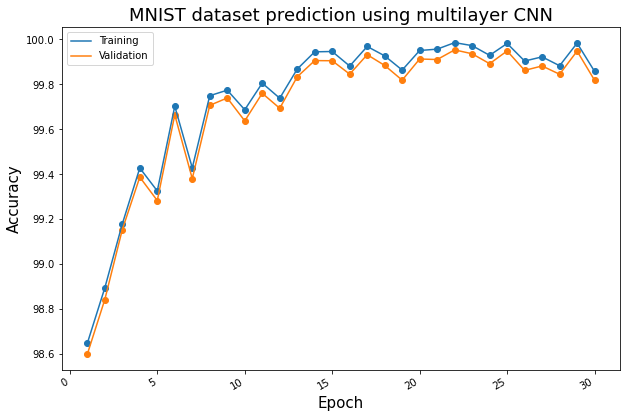

In [ ]:

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7))
fig.autofmt_xdate()
legend = np.zeros(6,dtype=object)
#for i in range(2):
x_axis = np.arange(0,30)
y_axis = training_accuracies
plt.scatter(x_axis+1, y_axis)
plt.plot(x_axis+1, y_axis, linestyle='solid')
y_axis = validation_accuracies
plt.scatter(x_axis+1, y_axis)
plt.plot(x_axis+1, y_axis, linestyle='solid')

legend = ("Training","Validation")
ax.legend(legend)
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title("MNIST dataset prediction using multilayer CNN",fontsize=18)
plt.show()

## Train CNN to predict unseen dataset

In [ ]:
full_dataset = xTrainingSet + xValidationSet
full_labels = yTrainingSet + yValidationSet

full_dataset_batch, full_labels_batch = create_batches(full_dataset, full_labels, batch_size)

net = Net(h_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

for epoch in range(max_iters):
    running_loss = 0.0
    
    for i, data in enumerate(full_dataset_batch):
        inputs = torch.from_numpy(data)
        labels = full_labels_batch[i] 
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, torch.from_numpy(np.array(labels).astype(np.longlong)))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 20 == 19:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

[1,    20] loss: 2.597
[1,    40] loss: 2.160
[1,    60] loss: 1.877
[1,    80] loss: 1.464
[1,   100] loss: 1.053
[1,   120] loss: 0.822
[1,   140] loss: 0.768
[1,   160] loss: 0.721
[1,   180] loss: 0.615
[1,   200] loss: 0.385
[1,   220] loss: 0.324
[1,   240] loss: 0.418
[1,   260] loss: 0.416
[1,   280] loss: 0.377
[1,   300] loss: 0.400
[1,   320] loss: 0.287
[1,   340] loss: 0.363
[1,   360] loss: 0.349
[1,   380] loss: 0.287
[1,   400] loss: 0.346
[1,   420] loss: 0.264
[1,   440] loss: 0.197
[1,   460] loss: 0.305
[1,   480] loss: 0.296
[1,   500] loss: 0.255
[1,   520] loss: 0.180
[1,   540] loss: 0.220
[1,   560] loss: 0.240
[1,   580] loss: 0.220
[1,   600] loss: 0.186
[1,   620] loss: 0.301
[1,   640] loss: 0.187
[1,   660] loss: 0.226
[1,   680] loss: 0.203
[1,   700] loss: 0.272
[1,   720] loss: 0.237
[1,   740] loss: 0.128
[1,   760] loss: 0.207
[1,   780] loss: 0.144
[1,   800] loss: 0.204
[1,   820] loss: 0.175
[1,   840] loss: 0.148
[1,   860] loss: 0.209
[1,   880] 

[1,  7160] loss: 0.081
[1,  7180] loss: 0.057
[1,  7200] loss: 0.054
[1,  7220] loss: 0.116
[1,  7240] loss: 0.134
[1,  7260] loss: 0.045
[1,  7280] loss: 0.077
[1,  7300] loss: 0.071
[1,  7320] loss: 0.033
[1,  7340] loss: 0.060
[1,  7360] loss: 0.047
[1,  7380] loss: 0.038
[1,  7400] loss: 0.110
[1,  7420] loss: 0.031
[1,  7440] loss: 0.054
[1,  7460] loss: 0.067
[1,  7480] loss: 0.078
[1,  7500] loss: 0.106
[1,  7520] loss: 0.094
[1,  7540] loss: 0.095
[1,  7560] loss: 0.065
[1,  7580] loss: 0.048
[1,  7600] loss: 0.087
[1,  7620] loss: 0.047
[1,  7640] loss: 0.080
[1,  7660] loss: 0.048
[1,  7680] loss: 0.041
[1,  7700] loss: 0.052
[1,  7720] loss: 0.048
[1,  7740] loss: 0.032
[1,  7760] loss: 0.014
[1,  7780] loss: 0.091
[1,  7800] loss: 0.045
[1,  7820] loss: 0.045
[1,  7840] loss: 0.031
[1,  7860] loss: 0.036
[1,  7880] loss: 0.077
[1,  7900] loss: 0.059
[1,  7920] loss: 0.020
[1,  7940] loss: 0.081
[1,  7960] loss: 0.046
[1,  7980] loss: 0.055
[1,  8000] loss: 0.084
[1,  8020] 

[2,  4440] loss: 0.029
[2,  4460] loss: 0.027
[2,  4480] loss: 0.024
[2,  4500] loss: 0.008
[2,  4520] loss: 0.011
[2,  4540] loss: 0.037
[2,  4560] loss: 0.028
[2,  4580] loss: 0.032
[2,  4600] loss: 0.071
[2,  4620] loss: 0.054
[2,  4640] loss: 0.037
[2,  4660] loss: 0.012
[2,  4680] loss: 0.027
[2,  4700] loss: 0.019
[2,  4720] loss: 0.054
[2,  4740] loss: 0.068
[2,  4760] loss: 0.042
[2,  4780] loss: 0.026
[2,  4800] loss: 0.079
[2,  4820] loss: 0.038
[2,  4840] loss: 0.043
[2,  4860] loss: 0.023
[2,  4880] loss: 0.029
[2,  4900] loss: 0.018
[2,  4920] loss: 0.022
[2,  4940] loss: 0.053
[2,  4960] loss: 0.049
[2,  4980] loss: 0.038
[2,  5000] loss: 0.076
[2,  5020] loss: 0.061
[2,  5040] loss: 0.057
[2,  5060] loss: 0.065
[2,  5080] loss: 0.057
[2,  5100] loss: 0.038
[2,  5120] loss: 0.043
[2,  5140] loss: 0.019
[2,  5160] loss: 0.032
[2,  5180] loss: 0.110
[2,  5200] loss: 0.017
[2,  5220] loss: 0.024
[2,  5240] loss: 0.017
[2,  5260] loss: 0.026
[2,  5280] loss: 0.015
[2,  5300] 

[3,  1720] loss: 0.019
[3,  1740] loss: 0.023
[3,  1760] loss: 0.065
[3,  1780] loss: 0.034
[3,  1800] loss: 0.017
[3,  1820] loss: 0.029
[3,  1840] loss: 0.035
[3,  1860] loss: 0.017
[3,  1880] loss: 0.005
[3,  1900] loss: 0.016
[3,  1920] loss: 0.021
[3,  1940] loss: 0.026
[3,  1960] loss: 0.017
[3,  1980] loss: 0.029
[3,  2000] loss: 0.038
[3,  2020] loss: 0.025
[3,  2040] loss: 0.121
[3,  2060] loss: 0.050
[3,  2080] loss: 0.020
[3,  2100] loss: 0.017
[3,  2120] loss: 0.028
[3,  2140] loss: 0.047
[3,  2160] loss: 0.026
[3,  2180] loss: 0.022
[3,  2200] loss: 0.020
[3,  2220] loss: 0.040
[3,  2240] loss: 0.027
[3,  2260] loss: 0.012
[3,  2280] loss: 0.011
[3,  2300] loss: 0.012
[3,  2320] loss: 0.028
[3,  2340] loss: 0.045
[3,  2360] loss: 0.009
[3,  2380] loss: 0.025
[3,  2400] loss: 0.021
[3,  2420] loss: 0.029
[3,  2440] loss: 0.020
[3,  2460] loss: 0.013
[3,  2480] loss: 0.039
[3,  2500] loss: 0.053
[3,  2520] loss: 0.039
[3,  2540] loss: 0.011
[3,  2560] loss: 0.018
[3,  2580] 

[3,  8860] loss: 0.018
[3,  8880] loss: 0.010
[3,  8900] loss: 0.010
[3,  8920] loss: 0.012
[3,  8940] loss: 0.024
[3,  8960] loss: 0.026
[3,  8980] loss: 0.014
[3,  9000] loss: 0.007
[3,  9020] loss: 0.018
[3,  9040] loss: 0.018
[3,  9060] loss: 0.022
[3,  9080] loss: 0.029
[3,  9100] loss: 0.019
[3,  9120] loss: 0.019
[3,  9140] loss: 0.029
[3,  9160] loss: 0.011
[3,  9180] loss: 0.053
[3,  9200] loss: 0.020
[3,  9220] loss: 0.007
[3,  9240] loss: 0.025
[3,  9260] loss: 0.028
[3,  9280] loss: 0.028
[3,  9300] loss: 0.020
[3,  9320] loss: 0.031
[3,  9340] loss: 0.015
[3,  9360] loss: 0.029
[3,  9380] loss: 0.010
[3,  9400] loss: 0.019
[3,  9420] loss: 0.015
[3,  9440] loss: 0.005
[3,  9460] loss: 0.006
[3,  9480] loss: 0.007
[3,  9500] loss: 0.004
[3,  9520] loss: 0.035
[3,  9540] loss: 0.010
[3,  9560] loss: 0.003
[3,  9580] loss: 0.024
[3,  9600] loss: 0.015
[3,  9620] loss: 0.009
[3,  9640] loss: 0.016
[3,  9660] loss: 0.015
[3,  9680] loss: 0.011
[3,  9700] loss: 0.008
[3,  9720] 

[4,  6140] loss: 0.007
[4,  6160] loss: 0.018
[4,  6180] loss: 0.003
[4,  6200] loss: 0.013
[4,  6220] loss: 0.017
[4,  6240] loss: 0.022
[4,  6260] loss: 0.039
[4,  6280] loss: 0.025
[4,  6300] loss: 0.012
[4,  6320] loss: 0.015
[4,  6340] loss: 0.007
[4,  6360] loss: 0.007
[4,  6380] loss: 0.024
[4,  6400] loss: 0.010
[4,  6420] loss: 0.004
[4,  6440] loss: 0.035
[4,  6460] loss: 0.030
[4,  6480] loss: 0.021
[4,  6500] loss: 0.022
[4,  6520] loss: 0.018
[4,  6540] loss: 0.016
[4,  6560] loss: 0.042
[4,  6580] loss: 0.015
[4,  6600] loss: 0.005
[4,  6620] loss: 0.011
[4,  6640] loss: 0.066
[4,  6660] loss: 0.014
[4,  6680] loss: 0.031
[4,  6700] loss: 0.010
[4,  6720] loss: 0.012
[4,  6740] loss: 0.012
[4,  6760] loss: 0.021
[4,  6780] loss: 0.022
[4,  6800] loss: 0.031
[4,  6820] loss: 0.024
[4,  6840] loss: 0.016
[4,  6860] loss: 0.055
[4,  6880] loss: 0.026
[4,  6900] loss: 0.013
[4,  6920] loss: 0.010
[4,  6940] loss: 0.014
[4,  6960] loss: 0.029
[4,  6980] loss: 0.015
[4,  7000] 

[5,  3420] loss: 0.015
[5,  3440] loss: 0.034
[5,  3460] loss: 0.010
[5,  3480] loss: 0.010
[5,  3500] loss: 0.017
[5,  3520] loss: 0.006
[5,  3540] loss: 0.008
[5,  3560] loss: 0.004
[5,  3580] loss: 0.016
[5,  3600] loss: 0.011
[5,  3620] loss: 0.005
[5,  3640] loss: 0.002
[5,  3660] loss: 0.003
[5,  3680] loss: 0.011
[5,  3700] loss: 0.006
[5,  3720] loss: 0.005
[5,  3740] loss: 0.003
[5,  3760] loss: 0.002
[5,  3780] loss: 0.006
[5,  3800] loss: 0.005
[5,  3820] loss: 0.008
[5,  3840] loss: 0.002
[5,  3860] loss: 0.006
[5,  3880] loss: 0.019
[5,  3900] loss: 0.029
[5,  3920] loss: 0.010
[5,  3940] loss: 0.022
[5,  3960] loss: 0.011
[5,  3980] loss: 0.034
[5,  4000] loss: 0.030
[5,  4020] loss: 0.018
[5,  4040] loss: 0.024
[5,  4060] loss: 0.032
[5,  4080] loss: 0.011
[5,  4100] loss: 0.028
[5,  4120] loss: 0.010
[5,  4140] loss: 0.018
[5,  4160] loss: 0.004
[5,  4180] loss: 0.001
[5,  4200] loss: 0.019
[5,  4220] loss: 0.012
[5,  4240] loss: 0.005
[5,  4260] loss: 0.008
[5,  4280] 

[6,   700] loss: 0.019
[6,   720] loss: 0.005
[6,   740] loss: 0.002
[6,   760] loss: 0.016
[6,   780] loss: 0.017
[6,   800] loss: 0.010
[6,   820] loss: 0.029
[6,   840] loss: 0.002
[6,   860] loss: 0.004
[6,   880] loss: 0.006
[6,   900] loss: 0.015
[6,   920] loss: 0.009
[6,   940] loss: 0.007
[6,   960] loss: 0.018
[6,   980] loss: 0.011
[6,  1000] loss: 0.030
[6,  1020] loss: 0.010
[6,  1040] loss: 0.003
[6,  1060] loss: 0.003
[6,  1080] loss: 0.005
[6,  1100] loss: 0.005
[6,  1120] loss: 0.017
[6,  1140] loss: 0.005
[6,  1160] loss: 0.012
[6,  1180] loss: 0.005
[6,  1200] loss: 0.031
[6,  1220] loss: 0.006
[6,  1240] loss: 0.005
[6,  1260] loss: 0.008
[6,  1280] loss: 0.001
[6,  1300] loss: 0.017
[6,  1320] loss: 0.003
[6,  1340] loss: 0.002
[6,  1360] loss: 0.034
[6,  1380] loss: 0.010
[6,  1400] loss: 0.010
[6,  1420] loss: 0.029
[6,  1440] loss: 0.002
[6,  1460] loss: 0.009
[6,  1480] loss: 0.002
[6,  1500] loss: 0.003
[6,  1520] loss: 0.003
[6,  1540] loss: 0.009
[6,  1560] 

[6,  7840] loss: 0.017
[6,  7860] loss: 0.002
[6,  7880] loss: 0.005
[6,  7900] loss: 0.006
[6,  7920] loss: 0.020
[6,  7940] loss: 0.013
[6,  7960] loss: 0.007
[6,  7980] loss: 0.009
[6,  8000] loss: 0.014
[6,  8020] loss: 0.017
[6,  8040] loss: 0.013
[6,  8060] loss: 0.017
[6,  8080] loss: 0.006
[6,  8100] loss: 0.018
[6,  8120] loss: 0.001
[6,  8140] loss: 0.008
[6,  8160] loss: 0.013
[6,  8180] loss: 0.004
[6,  8200] loss: 0.007
[6,  8220] loss: 0.006
[6,  8240] loss: 0.003
[6,  8260] loss: 0.007
[6,  8280] loss: 0.028
[6,  8300] loss: 0.030
[6,  8320] loss: 0.011
[6,  8340] loss: 0.003
[6,  8360] loss: 0.016
[6,  8380] loss: 0.003
[6,  8400] loss: 0.011
[6,  8420] loss: 0.015
[6,  8440] loss: 0.010
[6,  8460] loss: 0.022
[6,  8480] loss: 0.012
[6,  8500] loss: 0.021
[6,  8520] loss: 0.074
[6,  8540] loss: 0.011
[6,  8560] loss: 0.005
[6,  8580] loss: 0.006
[6,  8600] loss: 0.013
[6,  8620] loss: 0.014
[6,  8640] loss: 0.027
[6,  8660] loss: 0.014
[6,  8680] loss: 0.003
[6,  8700] 

[7,  5120] loss: 0.007
[7,  5140] loss: 0.000
[7,  5160] loss: 0.005
[7,  5180] loss: 0.006
[7,  5200] loss: 0.002
[7,  5220] loss: 0.010
[7,  5240] loss: 0.008
[7,  5260] loss: 0.003
[7,  5280] loss: 0.003
[7,  5300] loss: 0.004
[7,  5320] loss: 0.005
[7,  5340] loss: 0.024
[7,  5360] loss: 0.009
[7,  5380] loss: 0.013
[7,  5400] loss: 0.016
[7,  5420] loss: 0.022
[7,  5440] loss: 0.004
[7,  5460] loss: 0.008
[7,  5480] loss: 0.009
[7,  5500] loss: 0.014
[7,  5520] loss: 0.017
[7,  5540] loss: 0.035
[7,  5560] loss: 0.026
[7,  5580] loss: 0.022
[7,  5600] loss: 0.060
[7,  5620] loss: 0.014
[7,  5640] loss: 0.004
[7,  5660] loss: 0.002
[7,  5680] loss: 0.003
[7,  5700] loss: 0.003
[7,  5720] loss: 0.000
[7,  5740] loss: 0.015
[7,  5760] loss: 0.007
[7,  5780] loss: 0.017
[7,  5800] loss: 0.011
[7,  5820] loss: 0.005
[7,  5840] loss: 0.001
[7,  5860] loss: 0.008
[7,  5880] loss: 0.021
[7,  5900] loss: 0.015
[7,  5920] loss: 0.005
[7,  5940] loss: 0.017
[7,  5960] loss: 0.001
[7,  5980] 

[8,  2400] loss: 0.003
[8,  2420] loss: 0.003
[8,  2440] loss: 0.008
[8,  2460] loss: 0.001
[8,  2480] loss: 0.007
[8,  2500] loss: 0.019
[8,  2520] loss: 0.022
[8,  2540] loss: 0.001
[8,  2560] loss: 0.002
[8,  2580] loss: 0.001
[8,  2600] loss: 0.002
[8,  2620] loss: 0.003
[8,  2640] loss: 0.001
[8,  2660] loss: 0.004
[8,  2680] loss: 0.003
[8,  2700] loss: 0.008
[8,  2720] loss: 0.005
[8,  2740] loss: 0.004
[8,  2760] loss: 0.036
[8,  2780] loss: 0.029
[8,  2800] loss: 0.003
[8,  2820] loss: 0.033
[8,  2840] loss: 0.009
[8,  2860] loss: 0.011
[8,  2880] loss: 0.002
[8,  2900] loss: 0.014
[8,  2920] loss: 0.002
[8,  2940] loss: 0.007
[8,  2960] loss: 0.011
[8,  2980] loss: 0.009
[8,  3000] loss: 0.010
[8,  3020] loss: 0.022
[8,  3040] loss: 0.005
[8,  3060] loss: 0.011
[8,  3080] loss: 0.003
[8,  3100] loss: 0.012
[8,  3120] loss: 0.003
[8,  3140] loss: 0.009
[8,  3160] loss: 0.004
[8,  3180] loss: 0.003
[8,  3200] loss: 0.004
[8,  3220] loss: 0.007
[8,  3240] loss: 0.007
[8,  3260] 

[8,  9540] loss: 0.004
[8,  9560] loss: 0.001
[8,  9580] loss: 0.013
[8,  9600] loss: 0.004
[8,  9620] loss: 0.002
[8,  9640] loss: 0.004
[8,  9660] loss: 0.002
[8,  9680] loss: 0.008
[8,  9700] loss: 0.007
[8,  9720] loss: 0.001
[8,  9740] loss: 0.001
[8,  9760] loss: 0.007
[8,  9780] loss: 0.008
[8,  9800] loss: 0.002
[8,  9820] loss: 0.001
[8,  9840] loss: 0.004
[8,  9860] loss: 0.004
[9,    20] loss: 0.002
[9,    40] loss: 0.004
[9,    60] loss: 0.003
[9,    80] loss: 0.000
[9,   100] loss: 0.008
[9,   120] loss: 0.001
[9,   140] loss: 0.003
[9,   160] loss: 0.003
[9,   180] loss: 0.001
[9,   200] loss: 0.007
[9,   220] loss: 0.001
[9,   240] loss: 0.001
[9,   260] loss: 0.002
[9,   280] loss: 0.004
[9,   300] loss: 0.004
[9,   320] loss: 0.005
[9,   340] loss: 0.000
[9,   360] loss: 0.002
[9,   380] loss: 0.001
[9,   400] loss: 0.001
[9,   420] loss: 0.024
[9,   440] loss: 0.005
[9,   460] loss: 0.012
[9,   480] loss: 0.016
[9,   500] loss: 0.000
[9,   520] loss: 0.000
[9,   540] 

[9,  6820] loss: 0.012
[9,  6840] loss: 0.010
[9,  6860] loss: 0.040
[9,  6880] loss: 0.008
[9,  6900] loss: 0.017
[9,  6920] loss: 0.003
[9,  6940] loss: 0.010
[9,  6960] loss: 0.001
[9,  6980] loss: 0.010
[9,  7000] loss: 0.005
[9,  7020] loss: 0.000
[9,  7040] loss: 0.018
[9,  7060] loss: 0.002
[9,  7080] loss: 0.001
[9,  7100] loss: 0.003
[9,  7120] loss: 0.001
[9,  7140] loss: 0.001
[9,  7160] loss: 0.004
[9,  7180] loss: 0.001
[9,  7200] loss: 0.010
[9,  7220] loss: 0.002
[9,  7240] loss: 0.019
[9,  7260] loss: 0.002
[9,  7280] loss: 0.001
[9,  7300] loss: 0.015
[9,  7320] loss: 0.009
[9,  7340] loss: 0.004
[9,  7360] loss: 0.002
[9,  7380] loss: 0.000
[9,  7400] loss: 0.001
[9,  7420] loss: 0.001
[9,  7440] loss: 0.000
[9,  7460] loss: 0.011
[9,  7480] loss: 0.007
[9,  7500] loss: 0.013
[9,  7520] loss: 0.003
[9,  7540] loss: 0.014
[9,  7560] loss: 0.039
[9,  7580] loss: 0.008
[9,  7600] loss: 0.014
[9,  7620] loss: 0.003
[9,  7640] loss: 0.009
[9,  7660] loss: 0.010
[9,  7680] 

[10,  3920] loss: 0.009
[10,  3940] loss: 0.014
[10,  3960] loss: 0.008
[10,  3980] loss: 0.000
[10,  4000] loss: 0.007
[10,  4020] loss: 0.009
[10,  4040] loss: 0.001
[10,  4060] loss: 0.000
[10,  4080] loss: 0.000
[10,  4100] loss: 0.008
[10,  4120] loss: 0.001
[10,  4140] loss: 0.001
[10,  4160] loss: 0.004
[10,  4180] loss: 0.001
[10,  4200] loss: 0.002
[10,  4220] loss: 0.000
[10,  4240] loss: 0.000
[10,  4260] loss: 0.001
[10,  4280] loss: 0.009
[10,  4300] loss: 0.003
[10,  4320] loss: 0.004
[10,  4340] loss: 0.021
[10,  4360] loss: 0.005
[10,  4380] loss: 0.001
[10,  4400] loss: 0.000
[10,  4420] loss: 0.012
[10,  4440] loss: 0.012
[10,  4460] loss: 0.001
[10,  4480] loss: 0.003
[10,  4500] loss: 0.000
[10,  4520] loss: 0.000
[10,  4540] loss: 0.009
[10,  4560] loss: 0.003
[10,  4580] loss: 0.005
[10,  4600] loss: 0.001
[10,  4620] loss: 0.003
[10,  4640] loss: 0.003
[10,  4660] loss: 0.020
[10,  4680] loss: 0.003
[10,  4700] loss: 0.001
[10,  4720] loss: 0.003
[10,  4740] loss

[11,   900] loss: 0.006
[11,   920] loss: 0.002
[11,   940] loss: 0.001
[11,   960] loss: 0.000
[11,   980] loss: 0.001
[11,  1000] loss: 0.004
[11,  1020] loss: 0.001
[11,  1040] loss: 0.001
[11,  1060] loss: 0.002
[11,  1080] loss: 0.000
[11,  1100] loss: 0.001
[11,  1120] loss: 0.000
[11,  1140] loss: 0.000
[11,  1160] loss: 0.004
[11,  1180] loss: 0.002
[11,  1200] loss: 0.010
[11,  1220] loss: 0.001
[11,  1240] loss: 0.006
[11,  1260] loss: 0.001
[11,  1280] loss: 0.009
[11,  1300] loss: 0.006
[11,  1320] loss: 0.001
[11,  1340] loss: 0.001
[11,  1360] loss: 0.004
[11,  1380] loss: 0.002
[11,  1400] loss: 0.044
[11,  1420] loss: 0.005
[11,  1440] loss: 0.010
[11,  1460] loss: 0.018
[11,  1480] loss: 0.026
[11,  1500] loss: 0.003
[11,  1520] loss: 0.014
[11,  1540] loss: 0.006
[11,  1560] loss: 0.019
[11,  1580] loss: 0.024
[11,  1600] loss: 0.019
[11,  1620] loss: 0.004
[11,  1640] loss: 0.013
[11,  1660] loss: 0.006
[11,  1680] loss: 0.002
[11,  1700] loss: 0.006
[11,  1720] loss

[11,  7740] loss: 0.001
[11,  7760] loss: 0.001
[11,  7780] loss: 0.008
[11,  7800] loss: 0.023
[11,  7820] loss: 0.001
[11,  7840] loss: 0.000
[11,  7860] loss: 0.006
[11,  7880] loss: 0.004
[11,  7900] loss: 0.000
[11,  7920] loss: 0.006
[11,  7940] loss: 0.011
[11,  7960] loss: 0.005
[11,  7980] loss: 0.013
[11,  8000] loss: 0.023
[11,  8020] loss: 0.025
[11,  8040] loss: 0.006
[11,  8060] loss: 0.005
[11,  8080] loss: 0.001
[11,  8100] loss: 0.002
[11,  8120] loss: 0.004
[11,  8140] loss: 0.005
[11,  8160] loss: 0.002
[11,  8180] loss: 0.005
[11,  8200] loss: 0.005
[11,  8220] loss: 0.007
[11,  8240] loss: 0.011
[11,  8260] loss: 0.013
[11,  8280] loss: 0.001
[11,  8300] loss: 0.028
[11,  8320] loss: 0.007
[11,  8340] loss: 0.006
[11,  8360] loss: 0.005
[11,  8380] loss: 0.006
[11,  8400] loss: 0.006
[11,  8420] loss: 0.057
[11,  8440] loss: 0.011
[11,  8460] loss: 0.009
[11,  8480] loss: 0.001
[11,  8500] loss: 0.003
[11,  8520] loss: 0.037
[11,  8540] loss: 0.007
[11,  8560] loss

[12,  4720] loss: 0.003
[12,  4740] loss: 0.001
[12,  4760] loss: 0.003
[12,  4780] loss: 0.002
[12,  4800] loss: 0.000
[12,  4820] loss: 0.001
[12,  4840] loss: 0.003
[12,  4860] loss: 0.001
[12,  4880] loss: 0.001
[12,  4900] loss: 0.000
[12,  4920] loss: 0.014
[12,  4940] loss: 0.002
[12,  4960] loss: 0.000
[12,  4980] loss: 0.000
[12,  5000] loss: 0.005
[12,  5020] loss: 0.004
[12,  5040] loss: 0.000
[12,  5060] loss: 0.000
[12,  5080] loss: 0.009
[12,  5100] loss: 0.004
[12,  5120] loss: 0.001
[12,  5140] loss: 0.000
[12,  5160] loss: 0.007
[12,  5180] loss: 0.035
[12,  5200] loss: 0.008
[12,  5220] loss: 0.001
[12,  5240] loss: 0.004
[12,  5260] loss: 0.000
[12,  5280] loss: 0.001
[12,  5300] loss: 0.002
[12,  5320] loss: 0.004
[12,  5340] loss: 0.000
[12,  5360] loss: 0.000
[12,  5380] loss: 0.012
[12,  5400] loss: 0.004
[12,  5420] loss: 0.001
[12,  5440] loss: 0.009
[12,  5460] loss: 0.017
[12,  5480] loss: 0.011
[12,  5500] loss: 0.000
[12,  5520] loss: 0.001
[12,  5540] loss

[13,  1700] loss: 0.005
[13,  1720] loss: 0.001
[13,  1740] loss: 0.004
[13,  1760] loss: 0.002
[13,  1780] loss: 0.005
[13,  1800] loss: 0.009
[13,  1820] loss: 0.007
[13,  1840] loss: 0.001
[13,  1860] loss: 0.001
[13,  1880] loss: 0.004
[13,  1900] loss: 0.006
[13,  1920] loss: 0.001
[13,  1940] loss: 0.001
[13,  1960] loss: 0.002
[13,  1980] loss: 0.000
[13,  2000] loss: 0.000
[13,  2020] loss: 0.001
[13,  2040] loss: 0.005
[13,  2060] loss: 0.005
[13,  2080] loss: 0.001
[13,  2100] loss: 0.001
[13,  2120] loss: 0.013
[13,  2140] loss: 0.014
[13,  2160] loss: 0.007
[13,  2180] loss: 0.001
[13,  2200] loss: 0.010
[13,  2220] loss: 0.004
[13,  2240] loss: 0.004
[13,  2260] loss: 0.000
[13,  2280] loss: 0.004
[13,  2300] loss: 0.001
[13,  2320] loss: 0.001
[13,  2340] loss: 0.015
[13,  2360] loss: 0.001
[13,  2380] loss: 0.004
[13,  2400] loss: 0.001
[13,  2420] loss: 0.000
[13,  2440] loss: 0.004
[13,  2460] loss: 0.000
[13,  2480] loss: 0.007
[13,  2500] loss: 0.004
[13,  2520] loss

[13,  8540] loss: 0.016
[13,  8560] loss: 0.002
[13,  8580] loss: 0.010
[13,  8600] loss: 0.018
[13,  8620] loss: 0.007
[13,  8640] loss: 0.004
[13,  8660] loss: 0.001
[13,  8680] loss: 0.002
[13,  8700] loss: 0.006
[13,  8720] loss: 0.001
[13,  8740] loss: 0.000
[13,  8760] loss: 0.001
[13,  8780] loss: 0.001
[13,  8800] loss: 0.003
[13,  8820] loss: 0.001
[13,  8840] loss: 0.000
[13,  8860] loss: 0.001
[13,  8880] loss: 0.000
[13,  8900] loss: 0.002
[13,  8920] loss: 0.002
[13,  8940] loss: 0.002
[13,  8960] loss: 0.001
[13,  8980] loss: 0.004
[13,  9000] loss: 0.009
[13,  9020] loss: 0.007
[13,  9040] loss: 0.002
[13,  9060] loss: 0.000
[13,  9080] loss: 0.001
[13,  9100] loss: 0.008
[13,  9120] loss: 0.003
[13,  9140] loss: 0.008
[13,  9160] loss: 0.001
[13,  9180] loss: 0.002
[13,  9200] loss: 0.011
[13,  9220] loss: 0.002
[13,  9240] loss: 0.010
[13,  9260] loss: 0.010
[13,  9280] loss: 0.002
[13,  9300] loss: 0.003
[13,  9320] loss: 0.001
[13,  9340] loss: 0.007
[13,  9360] loss

[14,  5520] loss: 0.001
[14,  5540] loss: 0.003
[14,  5560] loss: 0.000
[14,  5580] loss: 0.001
[14,  5600] loss: 0.001
[14,  5620] loss: 0.000
[14,  5640] loss: 0.001
[14,  5660] loss: 0.000
[14,  5680] loss: 0.000
[14,  5700] loss: 0.001
[14,  5720] loss: 0.000
[14,  5740] loss: 0.001
[14,  5760] loss: 0.001
[14,  5780] loss: 0.003
[14,  5800] loss: 0.009
[14,  5820] loss: 0.002
[14,  5840] loss: 0.003
[14,  5860] loss: 0.002
[14,  5880] loss: 0.000
[14,  5900] loss: 0.003
[14,  5920] loss: 0.010
[14,  5940] loss: 0.000
[14,  5960] loss: 0.004
[14,  5980] loss: 0.000
[14,  6000] loss: 0.006
[14,  6020] loss: 0.000
[14,  6040] loss: 0.005
[14,  6060] loss: 0.004
[14,  6080] loss: 0.016
[14,  6100] loss: 0.016
[14,  6120] loss: 0.001
[14,  6140] loss: 0.006
[14,  6160] loss: 0.001
[14,  6180] loss: 0.001
[14,  6200] loss: 0.001
[14,  6220] loss: 0.000
[14,  6240] loss: 0.009
[14,  6260] loss: 0.038
[14,  6280] loss: 0.007
[14,  6300] loss: 0.003
[14,  6320] loss: 0.040
[14,  6340] loss

[15,  2500] loss: 0.003
[15,  2520] loss: 0.001
[15,  2540] loss: 0.000
[15,  2560] loss: 0.003
[15,  2580] loss: 0.000
[15,  2600] loss: 0.000
[15,  2620] loss: 0.000
[15,  2640] loss: 0.002
[15,  2660] loss: 0.001
[15,  2680] loss: 0.000
[15,  2700] loss: 0.001
[15,  2720] loss: 0.006
[15,  2740] loss: 0.008
[15,  2760] loss: 0.007
[15,  2780] loss: 0.011
[15,  2800] loss: 0.003
[15,  2820] loss: 0.011
[15,  2840] loss: 0.001
[15,  2860] loss: 0.001
[15,  2880] loss: 0.001
[15,  2900] loss: 0.000
[15,  2920] loss: 0.002
[15,  2940] loss: 0.002
[15,  2960] loss: 0.000
[15,  2980] loss: 0.000
[15,  3000] loss: 0.001
[15,  3020] loss: 0.001
[15,  3040] loss: 0.000
[15,  3060] loss: 0.000
[15,  3080] loss: 0.000
[15,  3100] loss: 0.013
[15,  3120] loss: 0.001
[15,  3140] loss: 0.003
[15,  3160] loss: 0.005
[15,  3180] loss: 0.006
[15,  3200] loss: 0.025
[15,  3220] loss: 0.003
[15,  3240] loss: 0.003
[15,  3260] loss: 0.001
[15,  3280] loss: 0.019
[15,  3300] loss: 0.002
[15,  3320] loss

[15,  9340] loss: 0.001
[15,  9360] loss: 0.002
[15,  9380] loss: 0.000
[15,  9400] loss: 0.003
[15,  9420] loss: 0.000
[15,  9440] loss: 0.000
[15,  9460] loss: 0.000
[15,  9480] loss: 0.009
[15,  9500] loss: 0.002
[15,  9520] loss: 0.008
[15,  9540] loss: 0.004
[15,  9560] loss: 0.002
[15,  9580] loss: 0.001
[15,  9600] loss: 0.001
[15,  9620] loss: 0.001
[15,  9640] loss: 0.006
[15,  9660] loss: 0.003
[15,  9680] loss: 0.007
[15,  9700] loss: 0.011
[15,  9720] loss: 0.003
[15,  9740] loss: 0.004
[15,  9760] loss: 0.000
[15,  9780] loss: 0.001
[15,  9800] loss: 0.000
[15,  9820] loss: 0.001
[15,  9840] loss: 0.000
[15,  9860] loss: 0.009
[16,    20] loss: 0.001
[16,    40] loss: 0.001
[16,    60] loss: 0.003
[16,    80] loss: 0.000
[16,   100] loss: 0.000
[16,   120] loss: 0.002
[16,   140] loss: 0.001
[16,   160] loss: 0.000
[16,   180] loss: 0.000
[16,   200] loss: 0.000
[16,   220] loss: 0.000
[16,   240] loss: 0.001
[16,   260] loss: 0.000
[16,   280] loss: 0.000
[16,   300] loss

[16,  6320] loss: 0.001
[16,  6340] loss: 0.000
[16,  6360] loss: 0.001
[16,  6380] loss: 0.000
[16,  6400] loss: 0.002
[16,  6420] loss: 0.000
[16,  6440] loss: 0.001
[16,  6460] loss: 0.002
[16,  6480] loss: 0.000
[16,  6500] loss: 0.001
[16,  6520] loss: 0.001
[16,  6540] loss: 0.008
[16,  6560] loss: 0.009
[16,  6580] loss: 0.002
[16,  6600] loss: 0.004
[16,  6620] loss: 0.001
[16,  6640] loss: 0.000
[16,  6660] loss: 0.002
[16,  6680] loss: 0.003
[16,  6700] loss: 0.002
[16,  6720] loss: 0.001
[16,  6740] loss: 0.005
[16,  6760] loss: 0.002
[16,  6780] loss: 0.011
[16,  6800] loss: 0.000
[16,  6820] loss: 0.001
[16,  6840] loss: 0.000
[16,  6860] loss: 0.011
[16,  6880] loss: 0.004
[16,  6900] loss: 0.000
[16,  6920] loss: 0.001
[16,  6940] loss: 0.000
[16,  6960] loss: 0.000
[16,  6980] loss: 0.001
[16,  7000] loss: 0.000
[16,  7020] loss: 0.002
[16,  7040] loss: 0.030
[16,  7060] loss: 0.001
[16,  7080] loss: 0.006
[16,  7100] loss: 0.000
[16,  7120] loss: 0.001
[16,  7140] loss

[17,  3300] loss: 0.005
[17,  3320] loss: 0.001
[17,  3340] loss: 0.000
[17,  3360] loss: 0.014
[17,  3380] loss: 0.007
[17,  3400] loss: 0.005
[17,  3420] loss: 0.000
[17,  3440] loss: 0.009
[17,  3460] loss: 0.001
[17,  3480] loss: 0.001
[17,  3500] loss: 0.001
[17,  3520] loss: 0.001
[17,  3540] loss: 0.001
[17,  3560] loss: 0.001
[17,  3580] loss: 0.001
[17,  3600] loss: 0.013
[17,  3620] loss: 0.000
[17,  3640] loss: 0.000
[17,  3660] loss: 0.005
[17,  3680] loss: 0.001
[17,  3700] loss: 0.006
[17,  3720] loss: 0.002
[17,  3740] loss: 0.025
[17,  3760] loss: 0.000
[17,  3780] loss: 0.008
[17,  3800] loss: 0.025
[17,  3820] loss: 0.001
[17,  3840] loss: 0.025
[17,  3860] loss: 0.012
[17,  3880] loss: 0.002
[17,  3900] loss: 0.012
[17,  3920] loss: 0.001
[17,  3940] loss: 0.002
[17,  3960] loss: 0.004
[17,  3980] loss: 0.004
[17,  4000] loss: 0.001
[17,  4020] loss: 0.000
[17,  4040] loss: 0.000
[17,  4060] loss: 0.008
[17,  4080] loss: 0.001
[17,  4100] loss: 0.002
[17,  4120] loss

[18,   280] loss: 0.001
[18,   300] loss: 0.002
[18,   320] loss: 0.000
[18,   340] loss: 0.006
[18,   360] loss: 0.000
[18,   380] loss: 0.002
[18,   400] loss: 0.002
[18,   420] loss: 0.005
[18,   440] loss: 0.018
[18,   460] loss: 0.000
[18,   480] loss: 0.000
[18,   500] loss: 0.000
[18,   520] loss: 0.000
[18,   540] loss: 0.000
[18,   560] loss: 0.000
[18,   580] loss: 0.001
[18,   600] loss: 0.000
[18,   620] loss: 0.000
[18,   640] loss: 0.001
[18,   660] loss: 0.000
[18,   680] loss: 0.006
[18,   700] loss: 0.010
[18,   720] loss: 0.035
[18,   740] loss: 0.006
[18,   760] loss: 0.003
[18,   780] loss: 0.000
[18,   800] loss: 0.001
[18,   820] loss: 0.006
[18,   840] loss: 0.001
[18,   860] loss: 0.000
[18,   880] loss: 0.005
[18,   900] loss: 0.000
[18,   920] loss: 0.000
[18,   940] loss: 0.002
[18,   960] loss: 0.001
[18,   980] loss: 0.001
[18,  1000] loss: 0.000
[18,  1020] loss: 0.000
[18,  1040] loss: 0.000
[18,  1060] loss: 0.000
[18,  1080] loss: 0.000
[18,  1100] loss

[18,  7120] loss: 0.000
[18,  7140] loss: 0.000
[18,  7160] loss: 0.003
[18,  7180] loss: 0.007
[18,  7200] loss: 0.001
[18,  7220] loss: 0.000
[18,  7240] loss: 0.001
[18,  7260] loss: 0.000
[18,  7280] loss: 0.000
[18,  7300] loss: 0.001
[18,  7320] loss: 0.000
[18,  7340] loss: 0.004
[18,  7360] loss: 0.006
[18,  7380] loss: 0.002
[18,  7400] loss: 0.010
[18,  7420] loss: 0.002
[18,  7440] loss: 0.000
[18,  7460] loss: 0.004
[18,  7480] loss: 0.000
[18,  7500] loss: 0.008
[18,  7520] loss: 0.001
[18,  7540] loss: 0.001
[18,  7560] loss: 0.013
[18,  7580] loss: 0.003
[18,  7600] loss: 0.001
[18,  7620] loss: 0.000
[18,  7640] loss: 0.003
[18,  7660] loss: 0.013
[18,  7680] loss: 0.000
[18,  7700] loss: 0.011
[18,  7720] loss: 0.000
[18,  7740] loss: 0.023
[18,  7760] loss: 0.002
[18,  7780] loss: 0.001
[18,  7800] loss: 0.000
[18,  7820] loss: 0.001
[18,  7840] loss: 0.000
[18,  7860] loss: 0.000
[18,  7880] loss: 0.001
[18,  7900] loss: 0.000
[18,  7920] loss: 0.000
[18,  7940] loss

[19,  4100] loss: 0.005
[19,  4120] loss: 0.000
[19,  4140] loss: 0.014
[19,  4160] loss: 0.002
[19,  4180] loss: 0.003
[19,  4200] loss: 0.000
[19,  4220] loss: 0.000
[19,  4240] loss: 0.001
[19,  4260] loss: 0.000
[19,  4280] loss: 0.008
[19,  4300] loss: 0.001
[19,  4320] loss: 0.001
[19,  4340] loss: 0.003
[19,  4360] loss: 0.000
[19,  4380] loss: 0.001
[19,  4400] loss: 0.009
[19,  4420] loss: 0.000
[19,  4440] loss: 0.001
[19,  4460] loss: 0.006
[19,  4480] loss: 0.001
[19,  4500] loss: 0.000
[19,  4520] loss: 0.001
[19,  4540] loss: 0.009
[19,  4560] loss: 0.002
[19,  4580] loss: 0.001
[19,  4600] loss: 0.006
[19,  4620] loss: 0.004
[19,  4640] loss: 0.024
[19,  4660] loss: 0.009
[19,  4680] loss: 0.000
[19,  4700] loss: 0.011
[19,  4720] loss: 0.004
[19,  4740] loss: 0.001
[19,  4760] loss: 0.001
[19,  4780] loss: 0.012
[19,  4800] loss: 0.001
[19,  4820] loss: 0.009
[19,  4840] loss: 0.001
[19,  4860] loss: 0.000
[19,  4880] loss: 0.000
[19,  4900] loss: 0.000
[19,  4920] loss

[20,  1080] loss: 0.000
[20,  1100] loss: 0.001
[20,  1120] loss: 0.003
[20,  1140] loss: 0.000
[20,  1160] loss: 0.003
[20,  1180] loss: 0.000
[20,  1200] loss: 0.000
[20,  1220] loss: 0.000
[20,  1240] loss: 0.002
[20,  1260] loss: 0.000
[20,  1280] loss: 0.001
[20,  1300] loss: 0.000
[20,  1320] loss: 0.002
[20,  1340] loss: 0.000
[20,  1360] loss: 0.001
[20,  1380] loss: 0.009
[20,  1400] loss: 0.000
[20,  1420] loss: 0.000
[20,  1440] loss: 0.000
[20,  1460] loss: 0.002
[20,  1480] loss: 0.000
[20,  1500] loss: 0.000
[20,  1520] loss: 0.000
[20,  1540] loss: 0.001
[20,  1560] loss: 0.001
[20,  1580] loss: 0.001
[20,  1600] loss: 0.000
[20,  1620] loss: 0.000
[20,  1640] loss: 0.000
[20,  1660] loss: 0.000
[20,  1680] loss: 0.001
[20,  1700] loss: 0.000
[20,  1720] loss: 0.000
[20,  1740] loss: 0.000
[20,  1760] loss: 0.000
[20,  1780] loss: 0.000
[20,  1800] loss: 0.000
[20,  1820] loss: 0.001
[20,  1840] loss: 0.000
[20,  1860] loss: 0.000
[20,  1880] loss: 0.000
[20,  1900] loss

[20,  7920] loss: 0.014
[20,  7940] loss: 0.001
[20,  7960] loss: 0.009
[20,  7980] loss: 0.000
[20,  8000] loss: 0.002
[20,  8020] loss: 0.011
[20,  8040] loss: 0.007
[20,  8060] loss: 0.020
[20,  8080] loss: 0.001
[20,  8100] loss: 0.005
[20,  8120] loss: 0.002
[20,  8140] loss: 0.000
[20,  8160] loss: 0.007
[20,  8180] loss: 0.001
[20,  8200] loss: 0.001
[20,  8220] loss: 0.003
[20,  8240] loss: 0.000
[20,  8260] loss: 0.001
[20,  8280] loss: 0.010
[20,  8300] loss: 0.001
[20,  8320] loss: 0.005
[20,  8340] loss: 0.001
[20,  8360] loss: 0.001
[20,  8380] loss: 0.000
[20,  8400] loss: 0.017
[20,  8420] loss: 0.004
[20,  8440] loss: 0.005
[20,  8460] loss: 0.000
[20,  8480] loss: 0.001
[20,  8500] loss: 0.008
[20,  8520] loss: 0.004
[20,  8540] loss: 0.015
[20,  8560] loss: 0.017
[20,  8580] loss: 0.016
[20,  8600] loss: 0.001
[20,  8620] loss: 0.004
[20,  8640] loss: 0.002
[20,  8660] loss: 0.001
[20,  8680] loss: 0.000
[20,  8700] loss: 0.001
[20,  8720] loss: 0.000
[20,  8740] loss

[21,  4900] loss: 0.013
[21,  4920] loss: 0.000
[21,  4940] loss: 0.006
[21,  4960] loss: 0.000
[21,  4980] loss: 0.004
[21,  5000] loss: 0.000
[21,  5020] loss: 0.000
[21,  5040] loss: 0.000
[21,  5060] loss: 0.000
[21,  5080] loss: 0.000
[21,  5100] loss: 0.004
[21,  5120] loss: 0.001
[21,  5140] loss: 0.000
[21,  5160] loss: 0.003
[21,  5180] loss: 0.014
[21,  5200] loss: 0.009
[21,  5220] loss: 0.000
[21,  5240] loss: 0.003
[21,  5260] loss: 0.000
[21,  5280] loss: 0.001
[21,  5300] loss: 0.001
[21,  5320] loss: 0.000
[21,  5340] loss: 0.002
[21,  5360] loss: 0.002
[21,  5380] loss: 0.002
[21,  5400] loss: 0.000
[21,  5420] loss: 0.003
[21,  5440] loss: 0.000
[21,  5460] loss: 0.000
[21,  5480] loss: 0.001
[21,  5500] loss: 0.000
[21,  5520] loss: 0.001
[21,  5540] loss: 0.029
[21,  5560] loss: 0.015
[21,  5580] loss: 0.000
[21,  5600] loss: 0.005
[21,  5620] loss: 0.006
[21,  5640] loss: 0.000
[21,  5660] loss: 0.003
[21,  5680] loss: 0.000
[21,  5700] loss: 0.002
[21,  5720] loss

[22,  1880] loss: 0.001
[22,  1900] loss: 0.006
[22,  1920] loss: 0.000
[22,  1940] loss: 0.004
[22,  1960] loss: 0.001
[22,  1980] loss: 0.001
[22,  2000] loss: 0.001
[22,  2020] loss: 0.001
[22,  2040] loss: 0.013
[22,  2060] loss: 0.000
[22,  2080] loss: 0.006
[22,  2100] loss: 0.000
[22,  2120] loss: 0.021
[22,  2140] loss: 0.005
[22,  2160] loss: 0.005
[22,  2180] loss: 0.008
[22,  2200] loss: 0.002
[22,  2220] loss: 0.025
[22,  2240] loss: 0.001
[22,  2260] loss: 0.038
[22,  2280] loss: 0.001
[22,  2300] loss: 0.001
[22,  2320] loss: 0.031
[22,  2340] loss: 0.017
[22,  2360] loss: 0.002
[22,  2380] loss: 0.002
[22,  2400] loss: 0.001
[22,  2420] loss: 0.006
[22,  2440] loss: 0.005
[22,  2460] loss: 0.007
[22,  2480] loss: 0.018
[22,  2500] loss: 0.002
[22,  2520] loss: 0.002
[22,  2540] loss: 0.000
[22,  2560] loss: 0.002
[22,  2580] loss: 0.001
[22,  2600] loss: 0.004
[22,  2620] loss: 0.000
[22,  2640] loss: 0.000
[22,  2660] loss: 0.000
[22,  2680] loss: 0.003
[22,  2700] loss

[22,  8720] loss: 0.003
[22,  8740] loss: 0.005
[22,  8760] loss: 0.000
[22,  8780] loss: 0.001
[22,  8800] loss: 0.012
[22,  8820] loss: 0.001
[22,  8840] loss: 0.009
[22,  8860] loss: 0.005
[22,  8880] loss: 0.001
[22,  8900] loss: 0.001
[22,  8920] loss: 0.001
[22,  8940] loss: 0.004
[22,  8960] loss: 0.001
[22,  8980] loss: 0.007
[22,  9000] loss: 0.000
[22,  9020] loss: 0.001
[22,  9040] loss: 0.000
[22,  9060] loss: 0.011
[22,  9080] loss: 0.000
[22,  9100] loss: 0.005
[22,  9120] loss: 0.002
[22,  9140] loss: 0.000
[22,  9160] loss: 0.003
[22,  9180] loss: 0.007
[22,  9200] loss: 0.001
[22,  9220] loss: 0.000
[22,  9240] loss: 0.002
[22,  9260] loss: 0.000
[22,  9280] loss: 0.000
[22,  9300] loss: 0.000
[22,  9320] loss: 0.000
[22,  9340] loss: 0.000
[22,  9360] loss: 0.011
[22,  9380] loss: 0.002
[22,  9400] loss: 0.002
[22,  9420] loss: 0.000
[22,  9440] loss: 0.003
[22,  9460] loss: 0.000
[22,  9480] loss: 0.000
[22,  9500] loss: 0.000
[22,  9520] loss: 0.001
[22,  9540] loss

[23,  5700] loss: 0.000
[23,  5720] loss: 0.001
[23,  5740] loss: 0.000
[23,  5760] loss: 0.000
[23,  5780] loss: 0.001
[23,  5800] loss: 0.000
[23,  5820] loss: 0.000
[23,  5840] loss: 0.000
[23,  5860] loss: 0.000
[23,  5880] loss: 0.002
[23,  5900] loss: 0.000
[23,  5920] loss: 0.000
[23,  5940] loss: 0.000
[23,  5960] loss: 0.000
[23,  5980] loss: 0.000
[23,  6000] loss: 0.006
[23,  6020] loss: 0.000
[23,  6040] loss: 0.005
[23,  6060] loss: 0.000
[23,  6080] loss: 0.002
[23,  6100] loss: 0.002
[23,  6120] loss: 0.001
[23,  6140] loss: 0.000
[23,  6160] loss: 0.000
[23,  6180] loss: 0.000
[23,  6200] loss: 0.000
[23,  6220] loss: 0.008
[23,  6240] loss: 0.017
[23,  6260] loss: 0.023
[23,  6280] loss: 0.008
[23,  6300] loss: 0.001
[23,  6320] loss: 0.001
[23,  6340] loss: 0.004
[23,  6360] loss: 0.001
[23,  6380] loss: 0.001
[23,  6400] loss: 0.000
[23,  6420] loss: 0.007
[23,  6440] loss: 0.001
[23,  6460] loss: 0.000
[23,  6480] loss: 0.002
[23,  6500] loss: 0.002
[23,  6520] loss

[24,  2680] loss: 0.012
[24,  2700] loss: 0.000
[24,  2720] loss: 0.000
[24,  2740] loss: 0.000
[24,  2760] loss: 0.000
[24,  2780] loss: 0.000
[24,  2800] loss: 0.005
[24,  2820] loss: 0.000
[24,  2840] loss: 0.000
[24,  2860] loss: 0.000
[24,  2880] loss: 0.001
[24,  2900] loss: 0.000
[24,  2920] loss: 0.000
[24,  2940] loss: 0.000
[24,  2960] loss: 0.001
[24,  2980] loss: 0.000
[24,  3000] loss: 0.001
[24,  3020] loss: 0.000
[24,  3040] loss: 0.000
[24,  3060] loss: 0.000
[24,  3080] loss: 0.000
[24,  3100] loss: 0.000
[24,  3120] loss: 0.000
[24,  3140] loss: 0.000
[24,  3160] loss: 0.000
[24,  3180] loss: 0.003
[24,  3200] loss: 0.002
[24,  3220] loss: 0.000
[24,  3240] loss: 0.001
[24,  3260] loss: 0.002
[24,  3280] loss: 0.000
[24,  3300] loss: 0.000
[24,  3320] loss: 0.001
[24,  3340] loss: 0.000
[24,  3360] loss: 0.000
[24,  3380] loss: 0.021
[24,  3400] loss: 0.013
[24,  3420] loss: 0.000
[24,  3440] loss: 0.001
[24,  3460] loss: 0.005
[24,  3480] loss: 0.007
[24,  3500] loss

[24,  9520] loss: 0.000
[24,  9540] loss: 0.000
[24,  9560] loss: 0.000
[24,  9580] loss: 0.004
[24,  9600] loss: 0.000
[24,  9620] loss: 0.000
[24,  9640] loss: 0.000
[24,  9660] loss: 0.003
[24,  9680] loss: 0.000
[24,  9700] loss: 0.000
[24,  9720] loss: 0.000
[24,  9740] loss: 0.000
[24,  9760] loss: 0.000
[24,  9780] loss: 0.000
[24,  9800] loss: 0.000
[24,  9820] loss: 0.000
[24,  9840] loss: 0.000
[24,  9860] loss: 0.000
[25,    20] loss: 0.000
[25,    40] loss: 0.000
[25,    60] loss: 0.007
[25,    80] loss: 0.000
[25,   100] loss: 0.000
[25,   120] loss: 0.022
[25,   140] loss: 0.002
[25,   160] loss: 0.000
[25,   180] loss: 0.002
[25,   200] loss: 0.000
[25,   220] loss: 0.000
[25,   240] loss: 0.015
[25,   260] loss: 0.006
[25,   280] loss: 0.000
[25,   300] loss: 0.006
[25,   320] loss: 0.001
[25,   340] loss: 0.003
[25,   360] loss: 0.001
[25,   380] loss: 0.001
[25,   400] loss: 0.000
[25,   420] loss: 0.000
[25,   440] loss: 0.000
[25,   460] loss: 0.000
[25,   480] loss

[25,  6500] loss: 0.001
[25,  6520] loss: 0.000
[25,  6540] loss: 0.001
[25,  6560] loss: 0.002
[25,  6580] loss: 0.000
[25,  6600] loss: 0.000
[25,  6620] loss: 0.006
[25,  6640] loss: 0.001
[25,  6660] loss: 0.000
[25,  6680] loss: 0.002
[25,  6700] loss: 0.000
[25,  6720] loss: 0.000
[25,  6740] loss: 0.000
[25,  6760] loss: 0.012
[25,  6780] loss: 0.001
[25,  6800] loss: 0.000
[25,  6820] loss: 0.005
[25,  6840] loss: 0.009
[25,  6860] loss: 0.005
[25,  6880] loss: 0.012
[25,  6900] loss: 0.017
[25,  6920] loss: 0.006
[25,  6940] loss: 0.000
[25,  6960] loss: 0.015
[25,  6980] loss: 0.000
[25,  7000] loss: 0.004
[25,  7020] loss: 0.001
[25,  7040] loss: 0.001
[25,  7060] loss: 0.001
[25,  7080] loss: 0.002
[25,  7100] loss: 0.001
[25,  7120] loss: 0.000
[25,  7140] loss: 0.000
[25,  7160] loss: 0.012
[25,  7180] loss: 0.004
[25,  7200] loss: 0.007
[25,  7220] loss: 0.000
[25,  7240] loss: 0.001
[25,  7260] loss: 0.000
[25,  7280] loss: 0.000
[25,  7300] loss: 0.000
[25,  7320] loss

[26,  3480] loss: 0.000
[26,  3500] loss: 0.000
[26,  3520] loss: 0.000
[26,  3540] loss: 0.000
[26,  3560] loss: 0.000
[26,  3580] loss: 0.000
[26,  3600] loss: 0.000
[26,  3620] loss: 0.000
[26,  3640] loss: 0.000
[26,  3660] loss: 0.000
[26,  3680] loss: 0.000
[26,  3700] loss: 0.000
[26,  3720] loss: 0.000
[26,  3740] loss: 0.000
[26,  3760] loss: 0.000
[26,  3780] loss: 0.000
[26,  3800] loss: 0.000
[26,  3820] loss: 0.001
[26,  3840] loss: 0.000
[26,  3860] loss: 0.000
[26,  3880] loss: 0.000
[26,  3900] loss: 0.015
[26,  3920] loss: 0.007
[26,  3940] loss: 0.000
[26,  3960] loss: 0.001
[26,  3980] loss: 0.001
[26,  4000] loss: 0.001
[26,  4020] loss: 0.000
[26,  4040] loss: 0.007
[26,  4060] loss: 0.000
[26,  4080] loss: 0.000
[26,  4100] loss: 0.027
[26,  4120] loss: 0.000
[26,  4140] loss: 0.000
[26,  4160] loss: 0.000
[26,  4180] loss: 0.000
[26,  4200] loss: 0.000
[26,  4220] loss: 0.000
[26,  4240] loss: 0.001
[26,  4260] loss: 0.000
[26,  4280] loss: 0.002
[26,  4300] loss

[27,   460] loss: 0.000
[27,   480] loss: 0.000
[27,   500] loss: 0.000
[27,   520] loss: 0.000
[27,   540] loss: 0.000
[27,   560] loss: 0.001
[27,   580] loss: 0.000
[27,   600] loss: 0.001
[27,   620] loss: 0.000
[27,   640] loss: 0.000
[27,   660] loss: 0.001
[27,   680] loss: 0.000
[27,   700] loss: 0.002
[27,   720] loss: 0.002
[27,   740] loss: 0.000
[27,   760] loss: 0.001
[27,   780] loss: 0.001
[27,   800] loss: 0.000
[27,   820] loss: 0.004
[27,   840] loss: 0.001
[27,   860] loss: 0.001
[27,   880] loss: 0.000
[27,   900] loss: 0.000
[27,   920] loss: 0.001
[27,   940] loss: 0.000
[27,   960] loss: 0.000
[27,   980] loss: 0.000
[27,  1000] loss: 0.000
[27,  1020] loss: 0.000
[27,  1040] loss: 0.000
[27,  1060] loss: 0.001
[27,  1080] loss: 0.002
[27,  1100] loss: 0.000
[27,  1120] loss: 0.000
[27,  1140] loss: 0.000
[27,  1160] loss: 0.000
[27,  1180] loss: 0.000
[27,  1200] loss: 0.000
[27,  1220] loss: 0.000
[27,  1240] loss: 0.003
[27,  1260] loss: 0.007
[27,  1280] loss

[27,  7300] loss: 0.000
[27,  7320] loss: 0.000
[27,  7340] loss: 0.002
[27,  7360] loss: 0.000
[27,  7380] loss: 0.000
[27,  7400] loss: 0.002
[27,  7420] loss: 0.001
[27,  7440] loss: 0.000
[27,  7460] loss: 0.000
[27,  7480] loss: 0.001
[27,  7500] loss: 0.011
[27,  7520] loss: 0.000
[27,  7540] loss: 0.000
[27,  7560] loss: 0.000
[27,  7580] loss: 0.000
[27,  7600] loss: 0.003
[27,  7620] loss: 0.000
[27,  7640] loss: 0.001
[27,  7660] loss: 0.000
[27,  7680] loss: 0.001
[27,  7700] loss: 0.000
[27,  7720] loss: 0.000
[27,  7740] loss: 0.000
[27,  7760] loss: 0.000
[27,  7780] loss: 0.000
[27,  7800] loss: 0.000
[27,  7820] loss: 0.000
[27,  7840] loss: 0.000
[27,  7860] loss: 0.000
[27,  7880] loss: 0.000
[27,  7900] loss: 0.004
[27,  7920] loss: 0.002
[27,  7940] loss: 0.000
[27,  7960] loss: 0.000
[27,  7980] loss: 0.000
[27,  8000] loss: 0.000
[27,  8020] loss: 0.001
[27,  8040] loss: 0.000
[27,  8060] loss: 0.000
[27,  8080] loss: 0.000
[27,  8100] loss: 0.000
[27,  8120] loss

[28,  4280] loss: 0.000
[28,  4300] loss: 0.004
[28,  4320] loss: 0.000
[28,  4340] loss: 0.015
[28,  4360] loss: 0.001
[28,  4380] loss: 0.001
[28,  4400] loss: 0.000
[28,  4420] loss: 0.000
[28,  4440] loss: 0.000
[28,  4460] loss: 0.000
[28,  4480] loss: 0.001
[28,  4500] loss: 0.000
[28,  4520] loss: 0.001
[28,  4540] loss: 0.000
[28,  4560] loss: 0.008
[28,  4580] loss: 0.001
[28,  4600] loss: 0.007
[28,  4620] loss: 0.004
[28,  4640] loss: 0.002
[28,  4660] loss: 0.000
[28,  4680] loss: 0.001
[28,  4700] loss: 0.000
[28,  4720] loss: 0.000
[28,  4740] loss: 0.014
[28,  4760] loss: 0.010
[28,  4780] loss: 0.001
[28,  4800] loss: 0.000
[28,  4820] loss: 0.000
[28,  4840] loss: 0.023
[28,  4860] loss: 0.004
[28,  4880] loss: 0.000
[28,  4900] loss: 0.000
[28,  4920] loss: 0.000
[28,  4940] loss: 0.005
[28,  4960] loss: 0.000
[28,  4980] loss: 0.003
[28,  5000] loss: 0.012
[28,  5020] loss: 0.001
[28,  5040] loss: 0.007
[28,  5060] loss: 0.001
[28,  5080] loss: 0.001
[28,  5100] loss

[29,  1260] loss: 0.007
[29,  1280] loss: 0.000
[29,  1300] loss: 0.000
[29,  1320] loss: 0.003
[29,  1340] loss: 0.000
[29,  1360] loss: 0.000
[29,  1380] loss: 0.001
[29,  1400] loss: 0.000
[29,  1420] loss: 0.000
[29,  1440] loss: 0.000
[29,  1460] loss: 0.000
[29,  1480] loss: 0.000
[29,  1500] loss: 0.000
[29,  1520] loss: 0.002
[29,  1540] loss: 0.000
[29,  1560] loss: 0.000
[29,  1580] loss: 0.000
[29,  1600] loss: 0.000
[29,  1620] loss: 0.000
[29,  1640] loss: 0.000
[29,  1660] loss: 0.000
[29,  1680] loss: 0.000
[29,  1700] loss: 0.000
[29,  1720] loss: 0.000
[29,  1740] loss: 0.001
[29,  1760] loss: 0.001
[29,  1780] loss: 0.000
[29,  1800] loss: 0.000
[29,  1820] loss: 0.000
[29,  1840] loss: 0.000
[29,  1860] loss: 0.000
[29,  1880] loss: 0.000
[29,  1900] loss: 0.000
[29,  1920] loss: 0.000
[29,  1940] loss: 0.000
[29,  1960] loss: 0.000
[29,  1980] loss: 0.000
[29,  2000] loss: 0.000
[29,  2020] loss: 0.000
[29,  2040] loss: 0.000
[29,  2060] loss: 0.000
[29,  2080] loss

[29,  8100] loss: 0.000
[29,  8120] loss: 0.000
[29,  8140] loss: 0.004
[29,  8160] loss: 0.002
[29,  8180] loss: 0.001
[29,  8200] loss: 0.001
[29,  8220] loss: 0.000
[29,  8240] loss: 0.010
[29,  8260] loss: 0.000
[29,  8280] loss: 0.000
[29,  8300] loss: 0.000
[29,  8320] loss: 0.001
[29,  8340] loss: 0.004
[29,  8360] loss: 0.001
[29,  8380] loss: 0.001
[29,  8400] loss: 0.000
[29,  8420] loss: 0.000
[29,  8440] loss: 0.003
[29,  8460] loss: 0.001
[29,  8480] loss: 0.000
[29,  8500] loss: 0.000
[29,  8520] loss: 0.001
[29,  8540] loss: 0.000
[29,  8560] loss: 0.000
[29,  8580] loss: 0.001
[29,  8600] loss: 0.000
[29,  8620] loss: 0.000
[29,  8640] loss: 0.000
[29,  8660] loss: 0.000
[29,  8680] loss: 0.000
[29,  8700] loss: 0.000
[29,  8720] loss: 0.000
[29,  8740] loss: 0.000
[29,  8760] loss: 0.000
[29,  8780] loss: 0.000
[29,  8800] loss: 0.000
[29,  8820] loss: 0.001
[29,  8840] loss: 0.000
[29,  8860] loss: 0.000
[29,  8880] loss: 0.000
[29,  8900] loss: 0.000
[29,  8920] loss

[30,  5080] loss: 0.001
[30,  5100] loss: 0.000
[30,  5120] loss: 0.000
[30,  5140] loss: 0.000
[30,  5160] loss: 0.000
[30,  5180] loss: 0.000
[30,  5200] loss: 0.004
[30,  5220] loss: 0.000
[30,  5240] loss: 0.001
[30,  5260] loss: 0.000
[30,  5280] loss: 0.000
[30,  5300] loss: 0.003
[30,  5320] loss: 0.000
[30,  5340] loss: 0.000
[30,  5360] loss: 0.001
[30,  5380] loss: 0.000
[30,  5400] loss: 0.000
[30,  5420] loss: 0.000
[30,  5440] loss: 0.000
[30,  5460] loss: 0.000
[30,  5480] loss: 0.000
[30,  5500] loss: 0.000
[30,  5520] loss: 0.000
[30,  5540] loss: 0.000
[30,  5560] loss: 0.000
[30,  5580] loss: 0.000
[30,  5600] loss: 0.000
[30,  5620] loss: 0.000
[30,  5640] loss: 0.000
[30,  5660] loss: 0.000
[30,  5680] loss: 0.000
[30,  5700] loss: 0.000
[30,  5720] loss: 0.000
[30,  5740] loss: 0.000
[30,  5760] loss: 0.000
[30,  5780] loss: 0.000
[30,  5800] loss: 0.000
[30,  5820] loss: 0.000
[30,  5840] loss: 0.002
[30,  5860] loss: 0.000
[30,  5880] loss: 0.005
[30,  5900] loss

## Predict unseen dataset

In [ ]:
separated_digits = []

for i, sample in enumerate(test_dataset):
    digits = []
    
    digits, n_digits = find_n_digits(sample)
        
    separated_digits.append(digits)
    
results = []

for i in range(len(test_dataset)):
    results.append([])

row = 0
col = 0
    
for i in range(int(num_test_digits / batch_size)):
    batch = []
    source = []
    count = 0
    
    while count < batch_size:
        batch.append(separated_digits[row][col])
        source.append((row, col))
        
        if(col < len(separated_digits[row]) - 1):
            col += 1
        else:
            row += 1
            col = 0
        
        count += 1
        
    batch = np.expand_dims(np.asarray(batch).astype(np.single), axis=1) 
    batch = torch.from_numpy(batch)
    
    output = net(batch)
    _, predicted = torch.max(output.data, 1)
    
    for j, pred in enumerate(predicted):
        coord = source[j]
        results[coord[0]].append(pred.item())
        
for r in results:
    pad = 5 - len(r)
    
    for i in range(pad):
        r.append(10)

In [ ]:
for i, sample in enumerate(test_dataset):
    displayGreyWindows(sample, "")
    print(results[i])

## Send data to csv

In [ ]:
Id = []
label = []
for i, x in enumerate(results):
    Id.append(i)
    string = ''.join([str(elem) for elem in x])
    label.append(string)

data={"Label":label}

df = pd.DataFrame(data)

df.to_csv('sample.csv', index_label = "Id")
df.head()



,Label
0,910101010
1,017310
2,14083
3,010101010
4,467810


## Hyperparameter Testing

*Hyperparameter Tuning Variables Initialization*

In [94]:
batch_sizes = [4, 8, 16, 24, 32, 64]
kernels = [3, 5, 7]
momentum_tests = [0.6, 0.7, 0.8, 0.9, 0.95]
learning_tests = [0.0001, 0.001, 0.01]
h_layers = [1, 2, 3, 4, 5, 6]

### Finding optimal batch size

In [19]:
training_accuracies = []
validation_accuracies = []

for batch_size in batch_sizes:

  training_dataset_batch, training_labels_batch = create_batches(xTrainingSet, yTrainingSet, batch_size)
  validation_dataset_batch, validation_labels_batch = create_batches(xValidationSet, yValidationSet, batch_size)

  # best model hyper-parameters
  h_layers = ([batch_size, 64])
  max_iters = 1
  learning_rate = 0.001
  momentum = 0.9


  dont_run = False
  # train neural network
  

  if not dont_run:
      net = Net(h_layers)
      criterion = nn.CrossEntropyLoss()
      optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

      for epoch in range(max_iters):
          running_loss = 0.0

          for i, data in enumerate(training_dataset_batch):
              inputs = torch.from_numpy(data)
              labels = training_labels_batch[i] 
              optimizer.zero_grad()
              outputs = net(inputs)
              loss = criterion(outputs, torch.from_numpy(np.array(labels).astype(np.longlong)))
              loss.backward()
              optimizer.step()

              running_loss += loss.item()

              if i % 20 == 19:
                  print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, running_loss / 20))
                  running_loss = 0.0

      # test validation set on model
          correct = 0
          total = 0


          with torch.no_grad():
              for i, data in enumerate(training_dataset_batch):
                  images = torch.from_numpy(data)
                  labels = training_labels_batch[i]
                  labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                  outputs = net(images)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  if (int(predicted[0]) != int(labels[0])):
                      None
                      
              training_accuracies.append(100 * correct / total)
          
          with torch.no_grad():
              for i, data in enumerate(validation_dataset_batch):
                  images = torch.from_numpy(data)
                  labels = validation_labels_batch[i]
                  labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                  outputs = net(images)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
                  if (int(predicted[0]) != int(labels[0])):
                      None
                      
              validation_accuracies.append(100 * correct / total)

      #print(f"validation set accuracy ({total} samples): {(100 * correct / total)}")

[1,    20] loss: 2.481
[1,    40] loss: 2.274
[1,    60] loss: 2.191
[1,    80] loss: 2.106
[1,   100] loss: 1.889
[1,   120] loss: 1.766
[1,   140] loss: 1.538
[1,   160] loss: 1.293
[1,   180] loss: 1.117
[1,   200] loss: 1.145
[1,   220] loss: 0.882
[1,   240] loss: 0.898
[1,   260] loss: 0.866
[1,   280] loss: 0.792
[1,   300] loss: 0.876
[1,   320] loss: 0.659
[1,   340] loss: 0.683
[1,   360] loss: 0.507
[1,   380] loss: 0.481
[1,   400] loss: 0.383
[1,   420] loss: 0.581
[1,   440] loss: 0.740
[1,   460] loss: 0.410
[1,   480] loss: 0.740
[1,   500] loss: 0.507
[1,   520] loss: 0.573
[1,   540] loss: 0.349
[1,   560] loss: 0.372
[1,   580] loss: 0.446
[1,   600] loss: 0.299
[1,   620] loss: 0.282
[1,   640] loss: 0.299
[1,   660] loss: 0.258
[1,   680] loss: 0.222
[1,   700] loss: 0.263
[1,   720] loss: 0.519
[1,   740] loss: 0.701
[1,   760] loss: 0.328
[1,   780] loss: 0.415
[1,   800] loss: 0.376
[1,   820] loss: 0.199
[1,   840] loss: 0.121
[1,   860] loss: 0.208
[1,   880] 

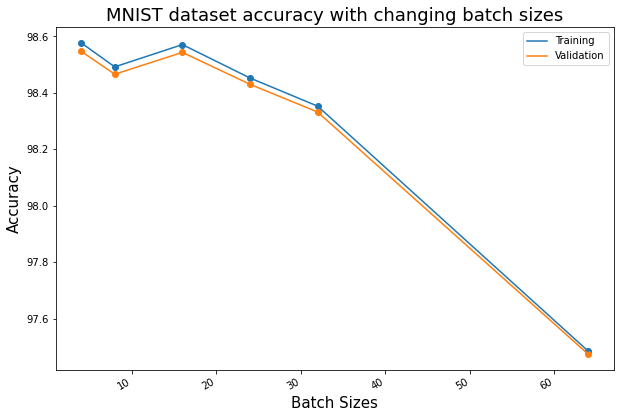

In [22]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7))
fig.autofmt_xdate()
legend = np.zeros(6,dtype=object)
#for i in range(2):
x_axis = batch_sizes
y_axis = training_accuracies
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')
y_axis = validation_accuracies
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')

legend = ("Training","Validation")
ax.legend(legend)
plt.xlabel('Batch Sizes',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title("MNIST dataset accuracy with changing batch sizes",fontsize=18)
plt.show()

### Finding optimal Kernel Size

In [92]:
training_accuracies = []
validation_accuracies = []

for kernel in kernels:

    training_dataset_batch, training_labels_batch = create_batches(xTrainingSet, yTrainingSet, batch_size)
    validation_dataset_batch, validation_labels_batch = create_batches(xValidationSet, yValidationSet, batch_size)

    # model hyper-parameters
    h_layers = ([batch_size, 64])
    max_iters = 1
    learning_rate = 0.001
    momentum = 0.9

    dont_run = False

    if not dont_run:
        net = Net(h_layers, kernel = kernel)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

        for epoch in range(max_iters):
            running_loss = 0.0

            for i, data in enumerate(training_dataset_batch):
                inputs = torch.from_numpy(data)
                labels = training_labels_batch[i] 
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, torch.from_numpy(np.array(labels).astype(np.longlong)))
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if i % 20 == 19:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    running_loss = 0.0

        # test validation set on model
            correct = 0
            total = 0


            with torch.no_grad():
                for i, data in enumerate(training_dataset_batch):
                    images = torch.from_numpy(data)
                    labels = training_labels_batch[i]
                    labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    if (int(predicted[0]) != int(labels[0])):
                        None
                        
                training_accuracies.append(100 * correct / total)
            
            with torch.no_grad():
                for i, data in enumerate(validation_dataset_batch):
                    images = torch.from_numpy(data)
                    labels = validation_labels_batch[i]
                    labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    if (int(predicted[0]) != int(labels[0])):
                        None
                        
                validation_accuracies.append(100 * correct / total)

        #print(f"validation set accuracy ({total} samples): {(100 * correct / total)}")

[1,    20] loss: 2.517
[1,    40] loss: 2.112
[1,    60] loss: 1.760
[1,    80] loss: 1.345
[1,   100] loss: 1.033
[1,   120] loss: 0.919
[1,   140] loss: 0.794
[1,   160] loss: 0.652
[1,   180] loss: 0.524
[1,   200] loss: 0.419
[1,   220] loss: 0.380
[1,   240] loss: 0.462
[1,   260] loss: 0.401
[1,   280] loss: 0.361
[1,   300] loss: 0.363
[1,   320] loss: 0.317
[1,   340] loss: 0.350
[1,   360] loss: 0.339
[1,   380] loss: 0.318
[1,   400] loss: 0.340
[1,   420] loss: 0.274
[1,   440] loss: 0.208
[1,   460] loss: 0.301
[1,   480] loss: 0.259
[1,   500] loss: 0.218
[1,   520] loss: 0.209
[1,   540] loss: 0.266
[1,   560] loss: 0.289
[1,   580] loss: 0.198
[1,   600] loss: 0.271
[1,   620] loss: 0.353
[1,   640] loss: 0.214
[1,   660] loss: 0.205
[1,   680] loss: 0.217
[1,   700] loss: 0.291
[1,   720] loss: 0.190
[1,   740] loss: 0.168
[1,   760] loss: 0.293
[1,   780] loss: 0.169
[1,   800] loss: 0.260
[1,   820] loss: 0.169
[1,   840] loss: 0.158
[1,   860] loss: 0.186
[1,   880] 

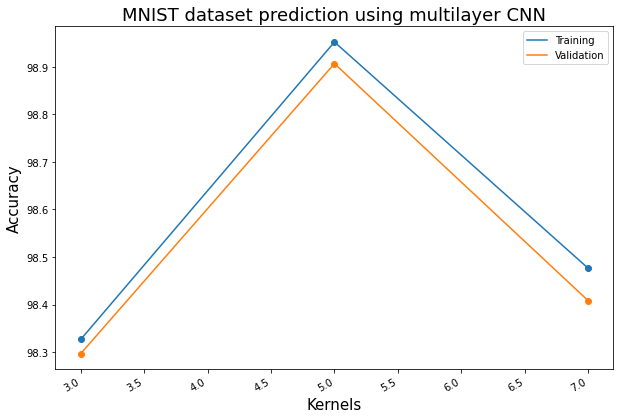

In [93]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7))
fig.autofmt_xdate()
legend = np.zeros(6,dtype=object)
#for i in range(2):
x_axis = kernels
y_axis = training_accuracies
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')
y_axis = validation_accuracies
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')

legend = ("Training","Validation")
ax.legend(legend)
plt.xlabel('Kernels',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title("MNIST dataset accuracy with changing kernel size",fontsize=18)
plt.show()

### Finding the optimal Momentum for SGD

In [ ]:
# Tune momentum
momentum_results_training = []
momentum_results_validation = []

training_dataset_batch, training_labels_batch = create_batches(xTrainingSet, yTrainingSet, batch_size)
validation_dataset_batch, validation_labels_batch = create_batches(xValidationSet, yValidationSet, batch_size)

for test in momentum_tests:
    max_iters = 1
    learning_rate = 0.001
    momentum = test

    dont_run = False

    if not dont_run:
        net = Net(h_layers)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
        
        correct_training = 0
        total_training = 0
            
        correct_validation = 0
        total_validation = 0

        for epoch in range(max_iters):
            running_loss = 0.0

            for i, data in enumerate(training_dataset_batch):
                inputs = torch.from_numpy(data)
                labels = training_labels_batch[i] 
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, torch.from_numpy(np.array(labels).astype(np.longlong)))
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if i % 20 == 19:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    running_loss = 0.0

            with torch.no_grad():
                for i, data in enumerate(training_dataset_batch):
                    images = torch.from_numpy(data)
                    labels = training_labels_batch[i]
                    labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_training += labels.size(0)
                    correct_training += (predicted == labels).sum().item()
                    if (int(predicted[0]) != int(labels[0])):
                        None

            with torch.no_grad():
                for i, data in enumerate(validation_dataset_batch):
                    images = torch.from_numpy(data)
                    labels = validation_labels_batch[i]
                    labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_validation += labels.size(0)
                    correct_validation += (predicted == labels).sum().item()
                    if (int(predicted[0]) != int(labels[0])):
                        None
        
        momentum_results_training.append(100 * correct_training / total_training)
        momentum_results_validation.append(100 * correct_validation / total_validation)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7))
fig.autofmt_xdate()
legend = np.zeros(6,dtype=object)
x_axis = momentum_tests
y_axis = momentum_results_training
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')
y_axis = momentum_results_validation
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')

legend = ("Training","Validation")
ax.legend(legend)
plt.xlabel('Momentum',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title("MNIST dataset accuracy with changing momentum",fontsize=18)
plt.show()

### Finding the optimal Learning Rate for SGD

In [ ]:
# Tune learning rate

learning_results_training = []
learning_results_validation = []

training_dataset_batch, training_labels_batch = create_batches(xTrainingSet, yTrainingSet, batch_size)
validation_dataset_batch, validation_labels_batch = create_batches(xValidationSet, yValidationSet, batch_size)

for test in learning_tests:
    max_iters = 1
    learning_rate = test
    momentum = 0.9

    dont_run = False

    if not dont_run:
        net = Net(h_layers)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
        
        correct_training = 0
        total_training = 0
            
        correct_validation = 0
        total_validation = 0

        for epoch in range(max_iters):
            running_loss = 0.0

            for i, data in enumerate(training_dataset_batch):
                inputs = torch.from_numpy(data)
                labels = training_labels_batch[i] 
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, torch.from_numpy(np.array(labels).astype(np.longlong)))
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                if i % 20 == 19:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    running_loss = 0.0

            with torch.no_grad():
                for i, data in enumerate(training_dataset_batch):
                    images = torch.from_numpy(data)
                    labels = training_labels_batch[i]
                    labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_training += labels.size(0)
                    correct_training += (predicted == labels).sum().item()
                    if (int(predicted[0]) != int(labels[0])):
                        None

            with torch.no_grad():
                for i, data in enumerate(validation_dataset_batch):
                    images = torch.from_numpy(data)
                    labels = validation_labels_batch[i]
                    labels = torch.from_numpy(np.array(labels).astype(np.longlong))
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total_validation += labels.size(0)
                    correct_validation += (predicted == labels).sum().item()
                    if (int(predicted[0]) != int(labels[0])):
                        None
        
        learning_results_training.append(100 * correct_training / total_training)
        learning_results_validation.append(100 * correct_validation / total_validation)

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 7))
fig.autofmt_xdate()
legend = np.zeros(6,dtype=object)
x_axis = learning_tests
y_axis = learning_results_training
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')
y_axis = learning_results_validation
plt.scatter(x_axis, y_axis)
plt.plot(x_axis, y_axis, linestyle='solid')
ax.set_xscale('log')
legend = ("Training","Validation")
ax.legend(legend)
plt.xlabel('Learning rate',fontsize=15)
plt.ylabel('Accuracy',fontsize=15)
plt.title("MNIST dataset accuracy with changing learning rate",fontsize=18)
plt.show()

### Finding the optimal number of Hidden Layers was done manually (please reference the Report for this graph)